<a href="https://colab.research.google.com/github/olivia-sp/h2-station-dev/blob/main/station_model_total_v1_5_olivia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
#ver0.1 - EDA
#ver0.2 - EDA 업데이트 및 모델 개선

#ver1.0 - POC1
#ver1.3 - POC2:피쳐추가
#ver1.4 - POC2:모델재학습

#DATASET - EDA

In [ ]:
import pandas as pd
import os

from sklearn.model_selection import train_test_split
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt


In [ ]:
import os

if os.path.isfile('/content/drive/MyDrive/Colab Notebooks/data_set/result-congress-26-tune1.csv') == True:
  print('already')
else:
  #os.mkdir('data_set')
  %cd data_set
  !wget https://raw.githubusercontent.com/olivia-sp/h2-station-dev/main/data_set/result-congress-26-tune1.csv

% cd /content


already


UsageError: Line magic function `%` not found.


In [ ]:
CURR_PATH = os.getcwd()

os.listdir(CURR_PATH)
#DATA_PATH = os.path.join(CURR_PATH,'data_set')
RAW_PATH = CURR_PATH + '/drive/MyDrive/Colab Notebooks/data_set/result-congress-26-tune1.csv'



In [ ]:
df_raw_data = pd.read_csv(RAW_PATH, index_col=0)
df_raw_data.info()

df_raw_data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77222 entries, 0 to 77436
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   holiday             77222 non-null  bool   
 1   weekend             77222 non-null  bool   
 2   time                77222 non-null  object 
 3   precipitation_type  46123 non-null  float64
 4   temperature         46123 non-null  float64
 5   station_name        77222 non-null  int64  
 6   filename            77222 non-null  object 
 7   precipitation       46123 non-null  float64
 8   total_car_num       77222 non-null  int64  
 9   day_week            77222 non-null  object 
 10  decision_car_num    76980 non-null  object 
 11  humid               46123 non-null  float64
 12  max_car_num         76907 non-null  float64
 13  year                77222 non-null  int64  
 14  month               77222 non-null  int64  
 15  day                 77222 non-null  int64  
 16  hour

holiday                   0
weekend                   0
time                      0
precipitation_type    31099
temperature           31099
station_name              0
filename                  0
precipitation         31099
total_car_num             0
day_week                  0
decision_car_num        242
humid                 31099
max_car_num             315
year                      0
month                     0
day                       0
hour                      0
minute                    0
second                    0
dtype: int64

In [ ]:
df_raw_data = df_raw_data.reset_index()

In [ ]:
df_raw_data2=df_raw_data.drop(['decision_car_num', 'max_car_num', 'filename', 'index'], axis=1)
df_raw_data2.isnull().sum()

holiday                   0
weekend                   0
time                      0
precipitation_type    31099
temperature           31099
station_name              0
precipitation         31099
total_car_num             0
day_week                  0
humid                 31099
year                      0
month                     0
day                       0
hour                      0
minute                    0
second                    0
dtype: int64

##POC1 - Basic EDA

###Holiday 처리

In [ ]:
!pip install holidays

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Holiday Data 추가   
import holidays

time_df = pd.DataFrame(df_raw_data2['time'])
time_df['time'] = pd.to_datetime(time_df['time'], format='%Y-%m-%d-%Hh-%Mm-%Ss', errors='raise')
time_df['date'] = time_df['time'].dt.date

holiday_list = time_df['date']


Year 끝 두자리로 변환

In [ ]:
#Year 끝 2자리 사용
time_df['year'] = time_df['time'].dt.strftime("%y")
time_df['year']
# time_df['year'] = time_df['time2'].dt.year

0        20
1        20
2        20
3        20
4        20
         ..
77217    22
77218    22
77219    22
77220    22
77221    22
Name: year, Length: 77222, dtype: object

In [ ]:
# 한국 휴일 개체 생성
kr_holidays = holidays.KR()

# generate holiday table 
holiday_df = pd.DataFrame(columns=['ds', 'imp_holiday'])
holiday_df['ds'] = holiday_list
holiday_df['imp_holiday'] = holiday_df.ds.apply(lambda x: 'True' if x in kr_holidays else 'False')

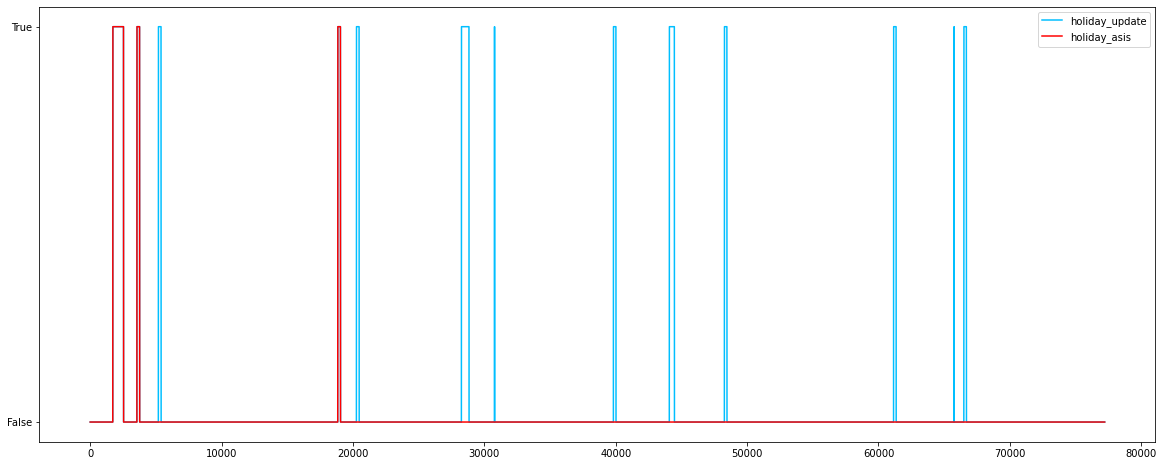

In [ ]:
# subplot 적용
fig = plt.figure(figsize = (20, 8))
chart = fig.add_subplot(1,1,1)


chart.plot(holiday_df['imp_holiday'], color='deepskyblue' , label='holiday_update')
chart.plot(df_raw_data2['holiday'], color='red' , label='holiday_asis')

#chart.plot(roll_mean20, color='pink' , label='')
plt.legend(loc = 'best')

In [ ]:
df_raw_data2['year'] = time_df['year'].astype(int)
df_raw_data2['holiday'] = holiday_df['imp_holiday']

###Season 및 Hour Group 추가

In [ ]:
def SeasonData(month):
    if month in [12,1,2]:
        return 'winter'
    elif month in [3,4,5]:
        return 'spring'
    elif month in [6,7,8]:
        return 'summer'
    elif month in [9,10,11]:
        return 'autumn'

df_raw_data2['season'] = df_raw_data2.month.apply(SeasonData)

Hour_group 데이터 생성
- Dawn 0시~7시
- Morning 7시~12시
- Lunch 12시~13시
- Day 13시~18시
- Dinner 18시~19시
- Night 19시~0시

In [ ]:
def HourGroupData(hour):
    if hour in [1,2,3,4,5,6]:
        return 'dawn'
    elif hour in [7,8,9,10,11]:
        return 'morning'
    elif hour in [12]:
        return 'lunch'
    elif hour in [13,14,15,16,17]:
        return 'afternoon'
    elif hour in [18]:
      return 'dinner'
    elif hour in [19, 20, 21, 22, 23, 0]:
      return 'night'

df_raw_data2['hour_group'] = df_raw_data2.hour.apply(HourGroupData)

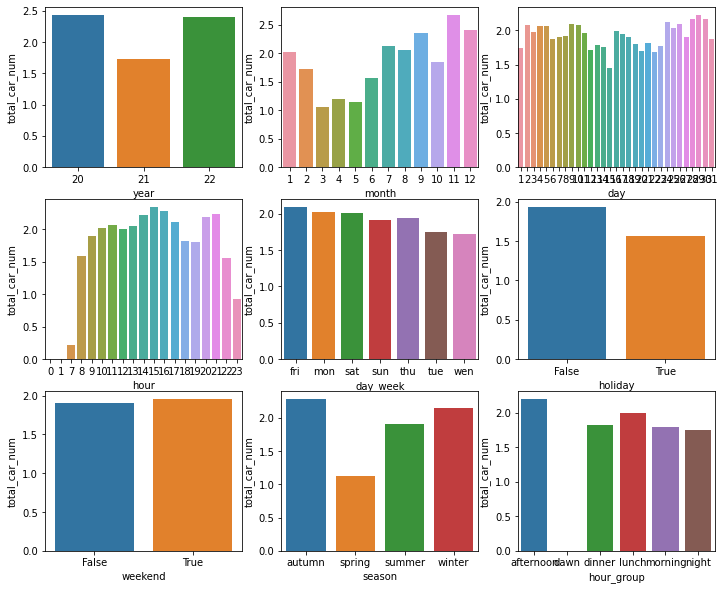

In [ ]:
#year와 count
fig = plt.figure(figsize=[12,10])
ax1 = fig.add_subplot(3,3,1)
ax1 = sns.barplot(x='year',y='total_car_num',data=df_raw_data2.groupby('year')['total_car_num'].mean().reset_index())

#month와 count
ax2 = fig.add_subplot(3,3,2)
ax2 = sns.barplot(x='month',y='total_car_num',data=df_raw_data2.groupby('month')['total_car_num'].mean().reset_index())

#day와 count
ax3 = fig.add_subplot(3,3,3)
ax3 = sns.barplot(x='day',y='total_car_num',data=df_raw_data2.groupby('day')['total_car_num'].mean().reset_index())

#hour와 count
ax4 = fig.add_subplot(3,3,4)
ax4 = sns.barplot(x='hour',y='total_car_num',data=df_raw_data2.groupby('hour')['total_car_num'].mean().reset_index())

#day_week과 count
ax5 = fig.add_subplot(3,3,5)
ax5 = sns.barplot(x='day_week',y='total_car_num',data=df_raw_data2.groupby('day_week')['total_car_num'].mean().reset_index())

#holiday와 count
ax6 = fig.add_subplot(3,3,6)
ax6 = sns.barplot(x='holiday',y='total_car_num',data=df_raw_data2.groupby('holiday')['total_car_num'].mean().reset_index())

#weekend와 count
ax7 = fig.add_subplot(3,3,7)
ax7 = sns.barplot(x='weekend',y='total_car_num',data=df_raw_data2.groupby('weekend')['total_car_num'].mean().reset_index())

#season과 count
ax8 = fig.add_subplot(3,3,8)
ax8 = sns.barplot(x='season',y='total_car_num',data=df_raw_data2.groupby('season')['total_car_num'].mean().reset_index())

#hour_group과 count
ax9 = fig.add_subplot(3,3,9)
ax9 = sns.barplot(x='hour_group',y='total_car_num',data=df_raw_data2.groupby('hour_group')['total_car_num'].mean().reset_index())

In [35]:
df_raw_data2.drop(df_raw_data.loc[df_raw_data['total_car_num'] == 6].index, inplace =True)
df_raw_data2.info()

df_raw_data2['holiday'] = df_raw_data['holiday'].astype(int)
df_raw_data2['weekend'] = df_raw_data['weekend'].astype(int)

NameError: ignored

In [ ]:
day_week_dum = pd.get_dummies(df_raw_data2['day_week'])
# df_raw_data3 + day_week_dum
df_dum1 = df_raw_data2.join(day_week_dum,how='left')

In [ ]:
season_dum = pd.get_dummies(df_dum1['season'])
# df_raw_data3 + day_week_dum
df_dum2 = df_dum1.join(season_dum,how='left')

In [ ]:
hrgroup_dum = pd.get_dummies(df_dum2['hour_group'])
# df_raw_data3 + day_week_dum
df_dum3 = df_dum2.join(hrgroup_dum,how='left')

In [ ]:
df_raw_data3=df_dum3.drop(['day_week', 'season', 'hour_group'], axis=1)
df_raw_data3

,holiday,weekend,time,precipitation_type,temperature,station_name,precipitation,total_car_num,humid,year,...,autumn,spring,summer,winter,afternoon,dawn,dinner,lunch,morning,night
0,0,0,2020-09-17-21h-20m-28s,0.0,23.0,26,0.0,2,52.0,20,...,1,0,0,0,0,0,0,0,0,1
1,0,0,2020-09-17-21h-38m-08s,0.0,23.0,26,0.0,3,52.0,20,...,1,0,0,0,0,0,0,0,0,1
2,0,0,2020-09-18-16h-45m-41s,0.0,25.3,26,0.0,4,38.0,20,...,1,0,0,0,1,0,0,0,0,0
3,0,0,2020-09-18-16h-50m-00s,0.0,25.3,26,0.0,4,38.0,20,...,1,0,0,0,1,0,0,0,0,0
4,0,0,2020-09-18-16h-55m-00s,0.0,25.3,26,0.0,4,38.0,20,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77217,0,0,2022-01-06-16h-40m-00s,NaN,NaN,26,NaN,3,NaN,22,...,0,0,0,1,1,0,0,0,0,0
77218,0,0,2022-01-06-16h-45m-00s,NaN,NaN,26,NaN,3,NaN,22,...,0,0,0,1,1,0,0,0,0,0
77219,0,0,2022-01-06-16h-50m-00s,NaN,NaN,26,NaN,4,NaN,22,...,0,0,0,1,1,0,0,0,0,0
77220,0,0,2022-01-06-16h-55m-00s,NaN,NaN,26,NaN,2,NaN,22,...,0,0,0,1,1,0,0,0,0,0


###결측값 처리

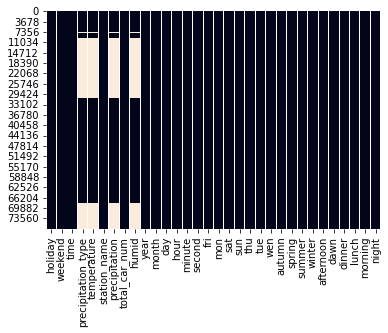

In [ ]:
%matplotlib inline
sns.heatmap(df_raw_data3.isnull(), cbar=False)

Data Imputation
1. mean/median : 작은 크기의 숫자형 데이터셋, 다른 feature 간 상관관계 고려 안 함, 범주형 feature 사용 불가, 부정확함
2. most frequent/zero/constant : 범주형 데이터셋, 다른 feature 간 상관관계 고려 안 함, 데이터 bias 생성 가능
3. KNN imputation : feature similarity  이용하여 근접한 데이터 찾음(impyute lib), 데이터셋에 따라 다르나 가장 정확함, 메모리 많이 필요, outlier에 민감
4. MICE : 누락된 데이터 여러번 채우는 방식, 연속형/이진형/범위형 패턴 처리 가능, imputation-analysis(m개의 완성된 데이터 분석)-pooling(평균,분산,신뢰구간 계산하여 합침)
5. 딥러닝 이용 : 범주형/non-numerical 데이터에 매우 효과적, DNN 이용해서 누락 값 유추, 한번에 한 컬럼만 대체 가능, 대규모 데이터셋은 속도가 상당히 느림, 유추할 feature에 대한 정보있는 feature 직접 지정해야 함
6. stochastic regression imputation : 동일 데이터셋의 다른 feature에서 결측값 예측
7. Extrapolation and Interpolation : 이산형 범위 내 데이터로부터 값 추정, interpolation(20살, 40살 데이터로 30살 추측), Extrapolation(1~20 데이터로 10년 후 예측, 안정성 떨어짐)
8. Hot-Deck Imputation : 비슷한 데이터셋에서 랜덤하게 선택


In [ ]:
df_null = df_raw_data3[['precipitation','precipitation_type', 'temperature', 'humid']]
df_raw_data4 = df_raw_data3.drop(['precipitation','precipitation_type', 'temperature', 'humid'], axis=1)
df_raw_data4

,holiday,weekend,time,station_name,total_car_num,year,month,day,hour,minute,...,autumn,spring,summer,winter,afternoon,dawn,dinner,lunch,morning,night
0,0,0,2020-09-17-21h-20m-28s,26,2,20,9,17,21,20,...,1,0,0,0,0,0,0,0,0,1
1,0,0,2020-09-17-21h-38m-08s,26,3,20,9,17,21,38,...,1,0,0,0,0,0,0,0,0,1
2,0,0,2020-09-18-16h-45m-41s,26,4,20,9,18,16,45,...,1,0,0,0,1,0,0,0,0,0
3,0,0,2020-09-18-16h-50m-00s,26,4,20,9,18,16,50,...,1,0,0,0,1,0,0,0,0,0
4,0,0,2020-09-18-16h-55m-00s,26,4,20,9,18,16,55,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77217,0,0,2022-01-06-16h-40m-00s,26,3,22,1,6,16,40,...,0,0,0,1,1,0,0,0,0,0
77218,0,0,2022-01-06-16h-45m-00s,26,3,22,1,6,16,45,...,0,0,0,1,1,0,0,0,0,0
77219,0,0,2022-01-06-16h-50m-00s,26,4,22,1,6,16,50,...,0,0,0,1,1,0,0,0,0,0
77220,0,0,2022-01-06-16h-55m-00s,26,2,22,1,6,16,55,...,0,0,0,1,1,0,0,0,0,0


####MICE

In [ ]:
!pip3 install impyute

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#다른 컬럼 상관관계 파악 필요
df_null_mice = df_raw_data3

In [ ]:
#df_null_mice.info()

In [ ]:
# time 잠시 빼고 결측치 보간
df_null_mice = df_null_mice.drop(['time'], axis=1)

In [ ]:
from impyute.imputation.cs import mice
imp_mice = mice(df_null_mice.values) # mice 학습시작
df_mice = pd.DataFrame(imp_mice, columns=df_null_mice.columns)

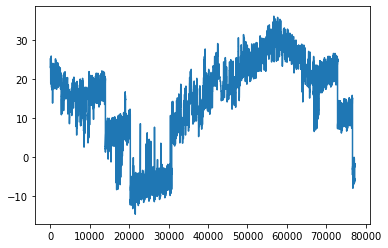

In [ ]:
df_mice['temperature'].plot()

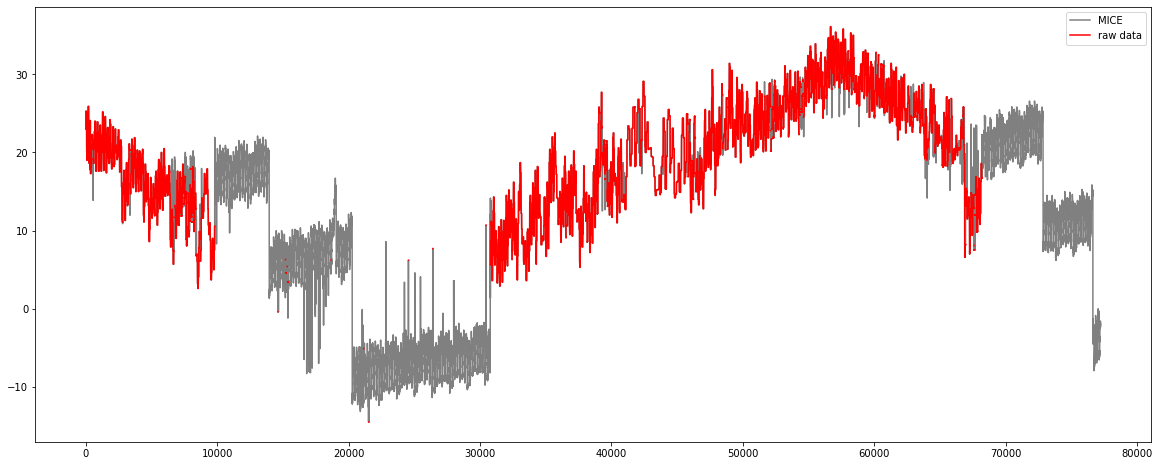

In [ ]:
# subplot 적용
fig = plt.figure(figsize = (20, 8))
chart = fig.add_subplot(1,1,1)

chart.plot(df_mice['temperature'], color='gray' , label='MICE')
chart.plot(df_raw_data3['temperature'], color='red' , label='raw data')
plt.legend(loc = 'best')

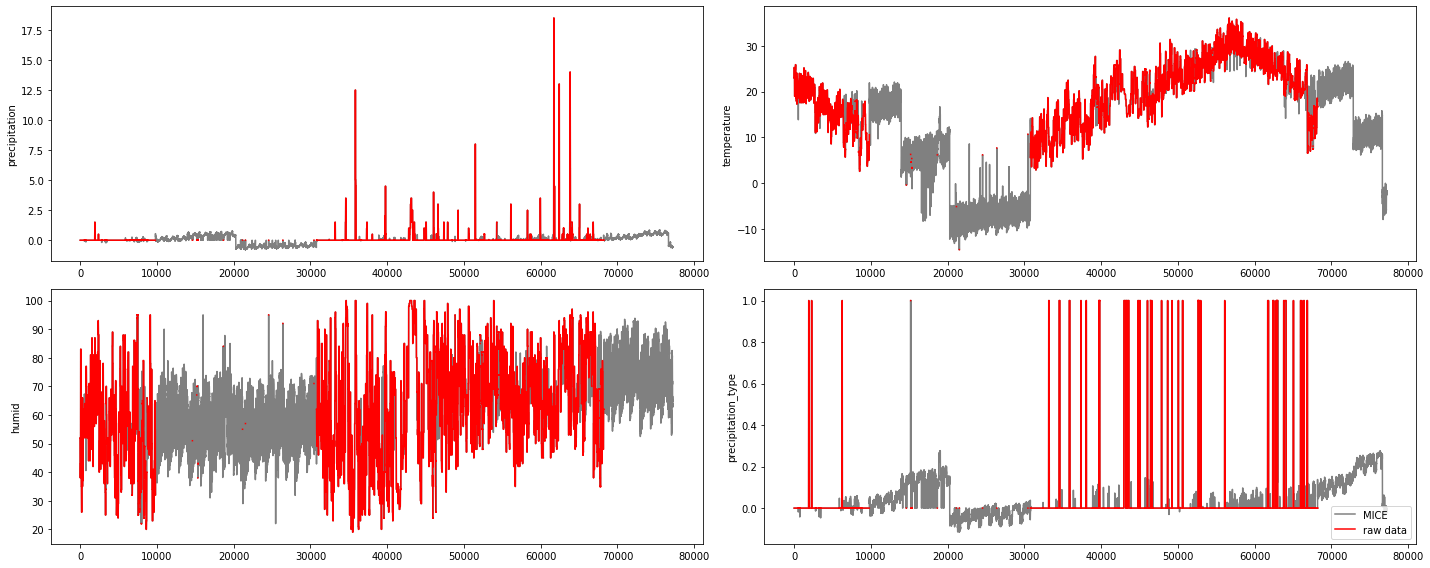

In [ ]:
# subplot 적용
plt.figure(figsize = (20, 8))

chart1 = plt.subplot(2,2,1)
plt.plot(df_mice['precipitation'], color='gray' , label='MICE')
plt.plot(df_raw_data2['precipitation'], color='red' , label='raw data')
plt.ylabel('precipitation')

chart2 = plt.subplot(2,2,2)
plt.plot(df_mice['temperature'], color='gray' , label='MICE')
plt.plot(df_raw_data2['temperature'], color='red' , label='raw data')
plt.ylabel('temperature')

chart3 = plt.subplot(2,2,3)
plt.plot(df_mice['humid'], color='gray' , label='MICE')
plt.plot(df_raw_data2['humid'], color='red' , label='raw data')
plt.ylabel('humid')

chart3 = plt.subplot(2,2,4)
plt.plot(df_mice['precipitation_type'], color='gray' , label='MICE')
plt.plot(df_raw_data2['precipitation_type'], color='red' , label='raw data')
plt.ylabel('precipitation_type')

#chart.plot(roll_mean20, color='pink' , label='')
plt.legend(loc = 'lower right')
plt.tight_layout()
plt.show()

In [ ]:
df_raw_data3['time'] = pd.to_datetime(df_raw_data3['time'], format='%Y-%m-%d-%Hh-%Mm-%Ss', errors='raise')

In [ ]:
df_mice['time'] = df_raw_data3['time']
df_mice

,holiday,weekend,precipitation_type,temperature,station_name,precipitation,total_car_num,humid,year,month,...,spring,summer,winter,afternoon,dawn,dinner,lunch,morning,night,time
0,0.0,0.0,0.000000,23.000000,26.0,0.000000,2.0,52.000000,20.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020-09-17 21:20:28
1,0.0,0.0,0.000000,23.000000,26.0,0.000000,3.0,52.000000,20.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020-09-17 21:38:08
2,0.0,0.0,0.000000,25.300000,26.0,0.000000,4.0,38.000000,20.0,9.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-09-18 16:45:41
3,0.0,0.0,0.000000,25.300000,26.0,0.000000,4.0,38.000000,20.0,9.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-09-18 16:50:00
4,0.0,0.0,0.000000,25.300000,26.0,0.000000,4.0,38.000000,20.0,9.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-09-18 16:55:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77217,0.0,0.0,-0.007601,-2.072026,26.0,-0.552183,3.0,63.496539,22.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2022-01-06 16:40:00
77218,0.0,0.0,-0.007816,-2.105922,26.0,-0.552909,3.0,63.463687,22.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2022-01-06 16:45:00
77219,0.0,0.0,-0.015731,-1.929274,26.0,-0.558184,4.0,62.784255,22.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2022-01-06 16:50:00
77220,0.0,0.0,-0.000545,-2.384258,26.0,-0.549811,2.0,64.044561,22.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2022-01-06 16:55:00


In [ ]:
df_mice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77222 entries, 0 to 77221
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   holiday             77222 non-null  float64       
 1   weekend             77222 non-null  float64       
 2   precipitation_type  77222 non-null  float64       
 3   temperature         77222 non-null  float64       
 4   station_name        77222 non-null  float64       
 5   precipitation       77222 non-null  float64       
 6   total_car_num       77222 non-null  float64       
 7   humid               77222 non-null  float64       
 8   year                77222 non-null  float64       
 9   month               77222 non-null  float64       
 10  day                 77222 non-null  float64       
 11  hour                77222 non-null  float64       
 12  minute              77222 non-null  float64       
 13  second              77222 non-null  float64   

In [ ]:
CURR_PATH = os.getcwd()
CURR_PATH

'/content'

In [ ]:
CURR_PATH = os.getcwd()

os.listdir(CURR_PATH)
#DATA_PATH = os.path.join(CURR_PATH,'data_set')
SAVE_PATH = CURR_PATH + '/drive/MyDrive/Colab Notebooks/data_set/data_imputation_MICE.csv'

In [ ]:
df_mice.to_csv(SAVE_PATH, index=True)

NameError: ignored

####[FILE] data_imputation_MICE.csv

In [ ]:
df_mice2 = pd.read_csv(SAVE_PATH, index_col=0)
df_mice2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 77222 entries, 0 to 77221
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   holiday             77222 non-null  float64
 1   weekend             77222 non-null  float64
 2   precipitation_type  77222 non-null  float64
 3   temperature         77222 non-null  float64
 4   station_name        77222 non-null  float64
 5   precipitation       77222 non-null  float64
 6   total_car_num       77222 non-null  float64
 7   humid               77222 non-null  float64
 8   year                77222 non-null  float64
 9   month               77222 non-null  float64
 10  day                 77222 non-null  float64
 11  hour                77222 non-null  float64
 12  minute              77222 non-null  float64
 13  second              77222 non-null  float64
 14  fri                 77222 non-null  float64
 15  mon                 77222 non-null  float64
 16  sat 

모델 적용

In [ ]:
df_new1 = df_mice2
df_new1 = df_new1[['total_car_num','holiday','weekend','precipitation_type','temperature','station_name','precipitation','humid','year','month','day','hour','minute','second','fri','mon','sat','sun','thu','tue','wen','autumn','spring','summer','winter','afternoon','dawn','dinner','lunch','morning','night','time']]

##POC2 - 피쳐추가

###수소차등록현황 추가

#### 데이터 수집

In [ ]:
import os

CURR_PATH = os.getcwd()
CURR_PATH
os.listdir(CURR_PATH)

['result-congress-26-tune1.csv',
 '도로안전표지현황(개방표준).csv',
 '횡단보도현황(개방표준).csv',
 '신호등현황(개방표준).csv',
 '도로터널정보현황(개방표준).csv',
 '일반음식점(복어취급)현황.csv',
 'data_imputation_MICE.csv',
 'output_h2car_register.csv',
 'h2station_location.csv']

In [ ]:
# 런타임 처음 실행
CURR_PATH = os.getcwd()
os.listdir(CURR_PATH)

SAVE_PATH = CURR_PATH + '/drive/MyDrive/Colab Notebooks/data_set/'
SAVE_PATH
os.chdir(SAVE_PATH)

In [ ]:
from inspect import getfile
import re
from urllib import request
from urllib.error import HTTPError
from bs4 import BeautifulSoup
import requests

#2020.09~
#FileName_2020 = [quote("2020년+12월+자동차+등록자료+통계.xlsx"), quote("2020년+11월+자동차+등록자료+통계.xlsx"), quote("2020년+10월+자동차+등록자료+통계.xlsx"), quote("2020년+09월+자동차+등록자료+통계.xlsx")]
FileName_2020 = ["2020년+12월+자동차+등록자료+통계.xlsx", "2020년+11월+자동차+등록자료+통계.xlsx", "2020년+10월+자동차+등록자료+통계.xlsx", "2020년+09월+자동차+등록자료+통계.xlsx"]
SaveName_2020 = ["2020년_12월_자동차_등록자료_통계.xlsx", "2020년_11월_자동차_등록자료_통계.xlsx", "2020년_10월_자동차_등록자료_통계.xlsx", "2020년_09월_자동차_등록자료_통계.xlsx"]


#2021
#FileName_2021 = [quote("2021년+12월+자동차+등록자료+통계.xlsx"), quote("2021년+11월+자동차+등록자료+통계.xlsx"), quote("2021년+10월+자동차+등록자료+통계.xlsx"), quote("2021년+09월+자동차+등록자료+통계.xlsx"), quote("2021년+08월+자동차+등록자료+통계.xlsx"), quote("2021년+07월+자동차+등록자료+통계.xlsx"), quote("2021년+06월+자동차+등록자료+통계.xlsx"), quote("2021년+05월+자동차+등록자료+통계.xlsx"), quote("2021년+04월+자동차+등록자료+통계.xlsx"), quote("2021년+03월+자동차+등록자료+통계.xlsx"), quote("2021년+02월+자동차+등록자료+통계.xlsx"), quote("2021년+01월+자동차+등록자료+통계.xlsx")]
FileName_2021 = ["2021년+12월+자동차+등록자료+통계 .xlsx", "2021년+11월+자동차+등록자료+통계.xlsx", "2021년+10월+자동차+등록자료+통계.xlsx", "2021년+09월+자동차+등록자료+통계 .xlsx", "2021년+08월+자동차+등록현황+통계.xlsx", "2021년+07월+자동차+등록자료+통계.xlsx", "2021년+06월+자동차+등록자료+통계.xlsx", "2021년+05월+자동차+등록자료+통계.xlsx", "2021년+04월+자동차+등록자료+통계.xlsx", "2021년+03월+자동차+등록자료+통계.xlsx", "2021년+02월+자동차+등록자료+통계.xlsx", "2021년+01월+자동차+등록자료+통계.xlsx"]
SaveName_2021 = ["2021년_12월_자동차_등록자료_통계.xlsx", "2021년_11월_자동차_등록자료_통계.xlsx", "2021년_10월_자동차_등록자료_통계.xlsx", "2021년_09월_자동차_등록자료_통계.xlsx", "2021년_08월_자동차_등록자료_통계.xlsx", "2021년_07월_자동차_등록자료_통계.xlsx", "2021년_06월_자동차_등록자료_통계.xlsx", "2021년_05월_자동차_등록자료_통계.xlsx", "2021년_04월_자동차_등록자료_통계.xlsx", "2021년_03월_자동차_등록자료_통계.xlsx", "2021년_02월_자동차_등록자료_통계.xlsx", "2021년_01월_자동차_등록자료_통계.xlsx"]

#2022
#FileName_2022 = [quote("2022년+07월+자동차+등록자료+통계.xlsx"), quote("2022년+06월+자동차+등록자료+통계.xlsx"), quote("2022년+05월+자동차+등록자료+통계.xlsx"), quote("2022년+04월+자동차+등록자료+통계.xlsx"), quote("2022년+03월+자동차+등록자료+통계.xlsx"), quote("2022년+02월+자동차+등록자료+통계.xlsx"), quote("2022년+01월+자동차+등록자료+통계.xlsx")]
FileName_2022 = ["2022년+07월+자동차+등록자료+통계.xlsx", "2022년+06월+자동차+등록자료+통계.xlsx", "2022년+05월+자동차+등록자료+통계.xlsx", "2022년+04월+자동차+등록자료+통계.xlsx", "2022년+03월+자동차+등록자료+통계.xlsx", "2022년+02월+자동차+등록자료+통계.xlsx", "2022년+01월+자동차+등록자료+통계.xlsx"]
SaveName_2022 = ["2022년_07월_자동차_등록자료_통계.xlsx", "2022년_06월_자동차_등록자료_통계.xlsx", "2022년_05월_자동차_등록자료_통계.xlsx", "2022년_04월_자동차_등록자료_통계.xlsx", "2022년_03월_자동차_등록자료_통계.xlsx", "2022년_02월_자동차_등록자료_통계.xlsx", "2022년_01월_자동차_등록자료_통계.xlsx"]


#2020 download
for i in range(0,len(FileName_2020)):
  print(FileName_2020[i])
  url = "https://stat.molit.go.kr/portal/common/downLoadFile.do?hRsId=58&hFormId=1244&hSelectId=1244&sStyleNum=562&sStart=2021&sEnd=2021&hPoint=00&hAppr=1&oFileName="+FileName_2020[i]+"&rFileName="+FileName_2020[i]+"&midpath=%2Fstat_file%2F"
  #ok url
  print(url)
  
  savename = SaveName_2020[i]

  r = requests.get(url)
  CurrentPath = os.getcwd() + "/" + savename
  with open(CurrentPath, "wb") as outfile:
    outfile.write(r.content)
    print(CurrentPath)


#2021 download
for i in range(0,len(FileName_2021)):
  print(FileName_2021[i])
  url = "https://stat.molit.go.kr/portal/common/downLoadFile.do?hRsId=58&hFormId=1244&hSelectId=1244&sStyleNum=562&sStart=2021&sEnd=2021&hPoint=00&hAppr=1&oFileName="+FileName_2021[i]+"&rFileName="+FileName_2021[i]+"&midpath=%2Fstat_file%2F"
  
  #ok url
  #url = "https://stat.molit.go.kr/portal/common/downLoadFile.do?hRsId=58&hFormId=1244&hSelectId=1244&sStyleNum=562&sStart=2021&sEnd=2021&hPoint=00&hAppr=1&oFileName=2022년+07월+자동차+등록자료+통계.xlsx&rFileName=2022년+07월+자동차+등록자료+통계.xlsx&midpath=%2Fstat_file%2F"
  #url = "https://stat.molit.go.kr/portal/common/downLoadFile.do?hRsId=58&hFormId=1244&hSelectId=1244&sStyleNum=562&sStart=2021&sEnd=2021&hPoint=00&hAppr=1&oFileName=2022%EB%85%84+07%EC%9B%94+%EC%9E%90%EB%8F%99%EC%B0%A8+%EB%93%B1%EB%A1%9D%EC%9E%90%EB%A3%8C+%ED%86%B5%EA%B3%84.xlsx&rFileName=2022%EB%85%84+07%EC%9B%94+%EC%9E%90%EB%8F%99%EC%B0%A8+%EB%93%B1%EB%A1%9D%EC%9E%90%EB%A3%8C+%ED%86%B5%EA%B3%84.xlsx&midpath=%2Fstat_file%2F"
  print(url)
  
  savename = SaveName_2021[i]

  r = requests.get(url)
  CurrentPath = os.getcwd() + "/" + savename
  with open(CurrentPath, "wb") as outfile:
    outfile.write(r.content)
    print(CurrentPath)


#2022 download
for i in range(0,len(FileName_2022)):
  print(FileName_2022[i])
  url = "https://stat.molit.go.kr/portal/common/downLoadFile.do?hRsId=58&hFormId=1244&hSelectId=1244&sStyleNum=562&sStart=2021&sEnd=2021&hPoint=00&hAppr=1&oFileName="+FileName_2022[i]+"&rFileName="+FileName_2022[i]+"&midpath=%2Fstat_file%2F"
  
  #ok url
  #url = "https://stat.molit.go.kr/portal/common/downLoadFile.do?hRsId=58&hFormId=1244&hSelectId=1244&sStyleNum=562&sStart=2021&sEnd=2021&hPoint=00&hAppr=1&oFileName=2022년+07월+자동차+등록자료+통계.xlsx&rFileName=2022년+07월+자동차+등록자료+통계.xlsx&midpath=%2Fstat_file%2F"
  #url = "https://stat.molit.go.kr/portal/common/downLoadFile.do?hRsId=58&hFormId=1244&hSelectId=1244&sStyleNum=562&sStart=2021&sEnd=2021&hPoint=00&hAppr=1&oFileName=2022%EB%85%84+07%EC%9B%94+%EC%9E%90%EB%8F%99%EC%B0%A8+%EB%93%B1%EB%A1%9D%EC%9E%90%EB%A3%8C+%ED%86%B5%EA%B3%84.xlsx&rFileName=2022%EB%85%84+07%EC%9B%94+%EC%9E%90%EB%8F%99%EC%B0%A8+%EB%93%B1%EB%A1%9D%EC%9E%90%EB%A3%8C+%ED%86%B5%EA%B3%84.xlsx&midpath=%2Fstat_file%2F"
  print(url)
  
  savename = SaveName_2022[i]

  r = requests.get(url)
  CurrentPath = os.getcwd() + "/" + savename
  with open(CurrentPath, "wb") as outfile:
    outfile.write(r.content)
    print(CurrentPath)

os.chdir('/content')



2020년+12월+자동차+등록자료+통계.xlsx
https://stat.molit.go.kr/portal/common/downLoadFile.do?hRsId=58&hFormId=1244&hSelectId=1244&sStyleNum=562&sStart=2021&sEnd=2021&hPoint=00&hAppr=1&oFileName=2020년+12월+자동차+등록자료+통계.xlsx&rFileName=2020년+12월+자동차+등록자료+통계.xlsx&midpath=%2Fstat_file%2F
/content/drive/MyDrive/Colab Notebooks/data_set/2020년_12월_자동차_등록자료_통계.xlsx
2020년+11월+자동차+등록자료+통계.xlsx
https://stat.molit.go.kr/portal/common/downLoadFile.do?hRsId=58&hFormId=1244&hSelectId=1244&sStyleNum=562&sStart=2021&sEnd=2021&hPoint=00&hAppr=1&oFileName=2020년+11월+자동차+등록자료+통계.xlsx&rFileName=2020년+11월+자동차+등록자료+통계.xlsx&midpath=%2Fstat_file%2F
/content/drive/MyDrive/Colab Notebooks/data_set/2020년_11월_자동차_등록자료_통계.xlsx
2020년+10월+자동차+등록자료+통계.xlsx
https://stat.molit.go.kr/portal/common/downLoadFile.do?hRsId=58&hFormId=1244&hSelectId=1244&sStyleNum=562&sStart=2021&sEnd=2021&hPoint=00&hAppr=1&oFileName=2020년+10월+자동차+등록자료+통계.xlsx&rFileName=2020년+10월+자동차+등록자료+통계.xlsx&midpath=%2Fstat_file%2F
/content/drive/MyDrive/Colab Notebook

In [ ]:
import pandas as pd
import os
import glob

CURR_PATH = os.getcwd()

os.listdir(CURR_PATH)
FILE_PATH = CURR_PATH + '/drive/MyDrive/Colab Notebooks/data_set/'
SAVE_H2CAR_PATH = CURR_PATH + '/drive/MyDrive/Colab Notebooks/data_set/output_h2car_register.csv'
SAVE_CAR_MERGE_PATH = CURR_PATH + '/drive/MyDrive/Colab Notebooks/data_set/output_merge_h2car.csv'
SAVE_H2CAR_RM_PATH = CURR_PATH + '/drive/MyDrive/Colab Notebooks/data_set/output_h2car_rm_dupl.csv'
MICE_PATH = CURR_PATH + '/drive/MyDrive/Colab Notebooks/data_set/data_imputation_MICE.csv'

In [ ]:
file_format = ".xlsx"
FILE_PATH = CURR_PATH + '/drive/MyDrive/Colab Notebooks/data_set'
file_list = [f"{FILE_PATH}/{file}" for file in os.listdir(FILE_PATH) if file_format in file]

In [ ]:
file_list

['/content/drive/MyDrive/Colab Notebooks/data_set/2020년_12월_자동차_등록자료_통계.xlsx',
 '/content/drive/MyDrive/Colab Notebooks/data_set/2020년_11월_자동차_등록자료_통계.xlsx',
 '/content/drive/MyDrive/Colab Notebooks/data_set/2020년_10월_자동차_등록자료_통계.xlsx',
 '/content/drive/MyDrive/Colab Notebooks/data_set/2020년_09월_자동차_등록자료_통계.xlsx',
 '/content/drive/MyDrive/Colab Notebooks/data_set/2021년_12월_자동차_등록자료_통계.xlsx',
 '/content/drive/MyDrive/Colab Notebooks/data_set/2021년_11월_자동차_등록자료_통계.xlsx',
 '/content/drive/MyDrive/Colab Notebooks/data_set/2021년_10월_자동차_등록자료_통계.xlsx',
 '/content/drive/MyDrive/Colab Notebooks/data_set/2021년_09월_자동차_등록자료_통계.xlsx',
 '/content/drive/MyDrive/Colab Notebooks/data_set/2021년_08월_자동차_등록자료_통계.xlsx',
 '/content/drive/MyDrive/Colab Notebooks/data_set/2021년_07월_자동차_등록자료_통계.xlsx',
 '/content/drive/MyDrive/Colab Notebooks/data_set/2021년_06월_자동차_등록자료_통계.xlsx',
 '/content/drive/MyDrive/Colab Notebooks/data_set/2021년_05월_자동차_등록자료_통계.xlsx',
 '/content/drive/MyDrive/Colab Notebooks/data_set/20

In [ ]:
!pip install openpyxl
!pip install --upgrade xlrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
result_out = {}

for file in file_list:
  print(file)
  #df_car = pd.read_excel(file, sheet_name = 9, engine='xlrd')
  df_car = pd.read_excel(file, sheet_name = 9, engine='openpyxl')

  df_car.drop(df_car.index[[2]], inplace=True)
  df_car.rename(columns = {'Unnamed: 0':'fuel', 'Unnamed: 1':'type','Unnamed: 2':'biz','<':'서울','연료별':'부산','차종별':'대구','용도별':'인천','등록현황':'광주','Unnamed: 8':'대전','>':'울산','Unnamed: 10':'세종','Unnamed: 11':'경기','Unnamed: 12':'강원','Unnamed: 13':'충북','Unnamed: 14':'충남','Unnamed: 15':'전북','Unnamed: 16':'전남','Unnamed: 17':'경북','Unnamed: 18':'경남','Unnamed: 19':'제주','Unnamed: 20':'h2car_regis_num'},inplace=True)
  df_car['fuel'].fillna(method='ffill', inplace=True)
  df_car['type'].fillna(method='ffill', inplace=True)
  df_car['date']=df_car['type'][0]
  df_h2 = df_car[df_car['fuel'].str.contains('수소')]
  df_h2.drop(df_h2.index[0:2], inplace=True)
  df_h2a = df_h2.reset_index(drop=True)
  if not os.path.exists(SAVE_H2CAR_PATH):
    df_h2a.to_csv(SAVE_H2CAR_PATH, index=False, mode='w', encoding='utf-8-sig')
  else:
    df_h2a.to_csv(SAVE_H2CAR_PATH, index=False, mode='a', encoding='utf-8-sig', header=False)    

/content/drive/MyDrive/Colab Notebooks/data_set/2020년_12월_자동차_등록자료_통계.xlsx
/content/drive/MyDrive/Colab Notebooks/data_set/2020년_11월_자동차_등록자료_통계.xlsx
/content/drive/MyDrive/Colab Notebooks/data_set/2020년_10월_자동차_등록자료_통계.xlsx
/content/drive/MyDrive/Colab Notebooks/data_set/2020년_09월_자동차_등록자료_통계.xlsx
/content/drive/MyDrive/Colab Notebooks/data_set/2021년_12월_자동차_등록자료_통계.xlsx
/content/drive/MyDrive/Colab Notebooks/data_set/2021년_11월_자동차_등록자료_통계.xlsx
/content/drive/MyDrive/Colab Notebooks/data_set/2021년_10월_자동차_등록자료_통계.xlsx
/content/drive/MyDrive/Colab Notebooks/data_set/2021년_09월_자동차_등록자료_통계.xlsx
/content/drive/MyDrive/Colab Notebooks/data_set/2021년_08월_자동차_등록자료_통계.xlsx
/content/drive/MyDrive/Colab Notebooks/data_set/2021년_07월_자동차_등록자료_통계.xlsx
/content/drive/MyDrive/Colab Notebooks/data_set/2021년_06월_자동차_등록자료_통계.xlsx
/content/drive/MyDrive/Colab Notebooks/data_set/2021년_05월_자동차_등록자료_통계.xlsx
/content/drive/MyDrive/Colab Notebooks/data_set/2021년_04월_자동차_등록자료_통계.xlsx
/content/drive/MyDrive/Co

####[FILE] output_h2car_rm_dupl.csv

In [ ]:
import pandas as pd
import os
import glob

CURR_PATH = os.getcwd()
os.listdir(CURR_PATH)
OUTPUT_CAR_PATH = CURR_PATH + '/drive/MyDrive/Colab Notebooks/data_set/output_h2car_register.csv'
OUTPUT_CAR_DB_PATH = CURR_PATH + '/drive/MyDrive/Colab Notebooks/data_set/output_h2car_dataset.csv'

In [ ]:
df_h2_new = pd.read_csv(OUTPUT_CAR_PATH, index_col=0)
df_h2_new.info()
df_h2_sum = df_h2_new[df_h2_new['type'].str.contains('소계')]
df_h2_sum = df_h2_sum[df_h2_sum['biz'].str.contains('계')]
df_h2_sum.sort_values(by=['date'], ascending=True, inplace=True)

<class 'pandas.core.frame.DataFrame'>
Index: 780 entries, 수소 to 수소
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   type             780 non-null    object 
 1   biz              780 non-null    object 
 2   서울               780 non-null    int64  
 3   부산               780 non-null    int64  
 4   대구               780 non-null    int64  
 5   인천               780 non-null    int64  
 6   광주               780 non-null    int64  
 7   대전               780 non-null    int64  
 8   울산               780 non-null    int64  
 9   세종               780 non-null    int64  
 10  경기               780 non-null    int64  
 11  강원               780 non-null    int64  
 12  충북               780 non-null    int64  
 13  충남               780 non-null    int64  
 14  전북               780 non-null    int64  
 15  전남               780 non-null    int64  
 16  경북               780 non-null    int64  
 17  경남               780 

In [ ]:
df_h2_sum.reset_index(inplace=True)
df_h2_sum.head(5)

,fuel,type,biz,서울,부산,대구,인천,광주,대전,울산,...,강원,충북,충남,전북,전남,경북,경남,제주,h2car_regis_num,date
0,수소,소계,계,1184,832,61,427,638,447,1680,...,810,294,426,321,100,14,827,1,9494,2020.09
1,수소,소계,계,1184,832,61,427,638,447,1680,...,810,294,426,321,100,14,827,1,9494,2020.09
2,수소,소계,계,1184,832,61,427,638,447,1680,...,810,294,426,321,100,14,827,1,9494,2020.09
3,수소,소계,계,1184,832,61,427,638,447,1680,...,810,294,426,321,100,14,827,1,9494,2020.09
4,수소,소계,계,1431,858,61,448,653,479,1721,...,821,307,442,342,108,15,856,0,10041,2020.10


In [ ]:
df_h2_sum.tail(5)

,fuel,type,biz,서울,부산,대구,인천,광주,대전,울산,...,강원,충북,충남,전북,전남,경북,경남,제주,h2car_regis_num,date
47,수소,소계,계,2432,1434,322,1101,976,892,2387,...,1857,993,836,1385,383,58,1812,4,20683,2022.03
48,수소,소계,계,2435,1473,352,1139,1018,1045,2395,...,1959,1095,908,1435,448,77,1899,5,21892,2022.04
49,수소,소계,계,2583,1539,372,1189,1029,1156,2393,...,2049,1170,990,1470,498,93,1955,4,23129,2022.05
50,수소,소계,계,2665,1599,389,1246,1019,1172,2393,...,2175,1246,1048,1493,541,110,2075,6,24119,2022.06
51,수소,소계,계,2702,1648,408,1307,1017,1191,2385,...,2219,1314,1068,1505,572,129,2135,5,24687,2022.07


In [ ]:
df_h2_sum.to_csv(OUTPUT_CAR_DB_PATH, index=True)

In [ ]:
#중복제거
df_h2_sum1 = df_h2_sum.drop_duplicates()
df_h2_sum1 = df_h2_sum1.reset_index(drop=True)
df_h2_sum1

In [ ]:
df_h2_sum1.to_csv(SAVE_H2CAR_RM_PATH, index=True)

####[FILE] output_merge_h2car.csv

In [ ]:
df_h2_sum['year'] = df_h2_sum['date'].astype(int)
df_h2_sum['month'] = (df_h2_sum['date'] % df_h2_sum['year']) * 100
df_h2_sum['year'] = df_h2_sum['year'] % 2000
df_h2_sum = df_h2_sum[['h2car_regis_num','date','year','month']]

In [ ]:
df_h2_sum

,h2car_regis_num,date,year,month
0,9494,2020.09,20,9.0
1,9494,2020.09,20,9.0
2,9494,2020.09,20,9.0
3,9494,2020.09,20,9.0
4,10041,2020.10,20,10.0
5,10041,2020.10,20,10.0
6,10041,2020.10,20,10.0
7,10041,2020.10,20,10.0
8,10477,2020.11,20,11.0
9,10477,2020.11,20,11.0


In [ ]:
df_mice2 = pd.read_csv(MICE_PATH, index_col=0)
df_new1 = df_mice2
df_new1 = df_new1[['total_car_num','holiday','weekend','precipitation_type','temperature','station_name','precipitation','humid','year','month','day','hour','minute','second','fri','mon','sat','sun','thu','tue','wen','autumn','spring','summer','winter','afternoon','dawn','dinner','lunch','morning','night','time']]

In [ ]:
#df_new1 : 위쪽 data_imputation_MICE.csv의 dataframe
df_new_h2 = df_new1
df_new_h2['date'] = (df_new_h2['year']+2000) + (df_new_h2['month']/100)
df_new_h2.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,total_car_num,holiday,weekend,precipitation_type,temperature,station_name,precipitation,humid,year,month,...,summer,winter,afternoon,dawn,dinner,lunch,morning,night,time,date
0,2.0,0.0,0.0,0.0,23.0,26.0,0.0,52.0,20.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020-09-17 21:20:28,2020.09
1,3.0,0.0,0.0,0.0,23.0,26.0,0.0,52.0,20.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020-09-17 21:38:08,2020.09
2,4.0,0.0,0.0,0.0,25.3,26.0,0.0,38.0,20.0,9.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-09-18 16:45:41,2020.09


In [ ]:
merge_df = pd.merge(df_new_h2, df_h2_sum, how='left', on='date')
merge_df.rename(columns = {'year_x':'year', 'month_x':'month'},inplace=True)
merge_df = merge_df.drop(['year_y', 'month_y'], axis=1)
merge_df

,total_car_num,holiday,weekend,precipitation_type,temperature,station_name,precipitation,humid,year,month,...,winter,afternoon,dawn,dinner,lunch,morning,night,time,date,h2car_regis_num
0,2.0,0.0,0.0,0.000000,23.000000,26.0,0.000000,52.000000,20.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020-09-17 21:20:28,2020.09,9494
1,2.0,0.0,0.0,0.000000,23.000000,26.0,0.000000,52.000000,20.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020-09-17 21:20:28,2020.09,9494
2,2.0,0.0,0.0,0.000000,23.000000,26.0,0.000000,52.000000,20.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020-09-17 21:20:28,2020.09,9494
3,2.0,0.0,0.0,0.000000,23.000000,26.0,0.000000,52.000000,20.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020-09-17 21:20:28,2020.09,9494
4,3.0,0.0,0.0,0.000000,23.000000,26.0,0.000000,52.000000,20.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020-09-17 21:38:08,2020.09,9494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207748,4.0,0.0,0.0,-0.015731,-1.929274,26.0,-0.558184,62.784255,22.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2022-01-06 16:50:00,2022.01,19613
207749,2.0,0.0,0.0,-0.000545,-2.384258,26.0,-0.549811,64.044561,22.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2022-01-06 16:55:00,2022.01,19613
207750,2.0,0.0,0.0,-0.000545,-2.384258,26.0,-0.549811,64.044561,22.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2022-01-06 16:55:00,2022.01,19613
207751,3.0,0.0,0.0,-0.004351,-1.645006,26.0,-0.542687,62.989278,22.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2022-01-06 17:00:00,2022.01,19613


In [ ]:
SAVE_CAR_MERGE_PATH

'/content/drive/MyDrive/Colab Notebooks/data_set/output_merge_h2car.csv'

In [ ]:
merge_df.to_csv(SAVE_CAR_MERGE_PATH, index=True)

###수소충전소등록현황 추가

In [1]:
import pandas as pd
import os
import glob

CURR_PATH = os.getcwd()

os.listdir(CURR_PATH)

SAVE_PATH = CURR_PATH + '/drive/MyDrive/Colab Notebooks/data_set/'
savename = '20220823_h2station_list.xlsx'
FILE_PATH = SAVE_PATH + savename
SAVE_H2CAR_RM_PATH = CURR_PATH + '/drive/MyDrive/Colab Notebooks/data_set/output_h2car_rm_dupl.csv'
SAVE_STATION_PATH = CURR_PATH + '/drive/MyDrive/Colab Notebooks/data_set/output_h2station_dataset.csv'
SAVE_CAR_MERGE_PATH = CURR_PATH + '/drive/MyDrive/Colab Notebooks/data_set/output_merge_h2car.csv'
MERGE_DB_PATH = CURR_PATH + '/drive/MyDrive/Colab Notebooks/data_set/output_merge_dataset.csv'
MERGE_FINAL_PATH = CURR_PATH + '/drive/MyDrive/Colab Notebooks/data_set/final_merge_dataset.csv'


In [2]:
os.chdir('/content')

In [3]:
CURR_PATH = os.getcwd()
CURR_PATH

'/content'

In [4]:
!pip install openpyxl
!pip install --upgrade xlrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 4.5 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [ ]:
df_from_excel = pd.read_excel(FILE_PATH, sheet_name=0,
                              header = 2, usecols=[1, 2, 3, 4], names=['regis_date', 'station_name', 'state', 'address'],
                              dtype={'regis_date':str, 'station_name':str, 'state':str, 'address':str},
                              engine='openpyxl'
                              #na_values='NaN'
                              )

In [ ]:
df_from_excel

,regis_date,station_name,state,address
0,2022-08-22 15:51:40.0,덕유산(대전방향)휴게소 수소충전소,전북,전북 무주군 안성면 통영대전고속도로 148
1,2022-08-22 15:42:38.0,오수(완주)휴게소 수소충전소,전북,전북 임실군 오수면 순천완주고속도로 74
2,2022-08-08 13:51:19.0,동해 충전소,강원,강원 동해시 동해대로 6427
3,2022-07-27 08:25:57.0,청주 문의수소충전소,충북,충북 청주시 상당구 문의면 미천고은로 61-1
4,2022-07-20 13:08:00.0,음성 하남 방향 수소 충전소,충북,충북 음성군 삼성면 중부고속도로 52
...,...,...,...,...
116,2019-10-10 11:29:44.0,내포수소충전소,충남,충남 홍성군 홍북읍 용봉로 234
117,2019-10-10 11:27:39.0,창원 성주 수소충전소,경남,경남 창원시 성산구 성주동 175
118,2019-10-10 11:23:06.0,서부산NK 수소충전소,부산,부산광역시 강서구 가락대로 347
119,2019-10-10 10:41:27.0,성주 휴게소(양평방향),경북,경북 성주군 초전면 중부내륙고속도로 98


In [ ]:
# 시계열 데이터 type 변환
df_from_excel['year'] = df_from_excel['regis_date'].apply(lambda year : year.split('-')[0])
df_from_excel['month'] = df_from_excel['regis_date'].apply(lambda month : month.split('-')[1])
df_from_excel

,regis_date,station_name,state,address,year,month
0,2022-08-22 15:51:40.0,덕유산(대전방향)휴게소 수소충전소,전북,전북 무주군 안성면 통영대전고속도로 148,2022,08
1,2022-08-22 15:42:38.0,오수(완주)휴게소 수소충전소,전북,전북 임실군 오수면 순천완주고속도로 74,2022,08
2,2022-08-08 13:51:19.0,동해 충전소,강원,강원 동해시 동해대로 6427,2022,08
3,2022-07-27 08:25:57.0,청주 문의수소충전소,충북,충북 청주시 상당구 문의면 미천고은로 61-1,2022,07
4,2022-07-20 13:08:00.0,음성 하남 방향 수소 충전소,충북,충북 음성군 삼성면 중부고속도로 52,2022,07
...,...,...,...,...,...,...
116,2019-10-10 11:29:44.0,내포수소충전소,충남,충남 홍성군 홍북읍 용봉로 234,2019,10
117,2019-10-10 11:27:39.0,창원 성주 수소충전소,경남,경남 창원시 성산구 성주동 175,2019,10
118,2019-10-10 11:23:06.0,서부산NK 수소충전소,부산,부산광역시 강서구 가락대로 347,2019,10
119,2019-10-10 10:41:27.0,성주 휴게소(양평방향),경북,경북 성주군 초전면 중부내륙고속도로 98,2019,10


In [ ]:
#address 쪼개기 - state, city, suburb
d0 = df_from_excel['address'].str.split(' ').str[0].tolist()
d1 = df_from_excel['address'].str.split(' ').str[1].tolist()
d2 = df_from_excel['address'].str.split(' ').str[2].tolist()
#d2 = list(map(str, d2))

df_data = df_from_excel
df_data['city'] = d1
df_data['suburb'] = d2

df_data = df_data.astype(str)
df_data['city'].str.strip()
df_data['suburb'].str.strip()

df_data=df_data[['regis_date', 'station_name', 'address', 'state', 'city', 'suburb', 'year', 'month']]
df_data

,regis_date,station_name,address,state,city,suburb,year,month
0,2022-08-22 15:51:40.0,덕유산(대전방향)휴게소 수소충전소,전북 무주군 안성면 통영대전고속도로 148,전북,무주군,안성면,2022,08
1,2022-08-22 15:42:38.0,오수(완주)휴게소 수소충전소,전북 임실군 오수면 순천완주고속도로 74,전북,임실군,오수면,2022,08
2,2022-08-08 13:51:19.0,동해 충전소,강원 동해시 동해대로 6427,강원,동해시,동해대로,2022,08
3,2022-07-27 08:25:57.0,청주 문의수소충전소,충북 청주시 상당구 문의면 미천고은로 61-1,충북,청주시,상당구,2022,07
4,2022-07-20 13:08:00.0,음성 하남 방향 수소 충전소,충북 음성군 삼성면 중부고속도로 52,충북,음성군,삼성면,2022,07
...,...,...,...,...,...,...,...,...
116,2019-10-10 11:29:44.0,내포수소충전소,충남 홍성군 홍북읍 용봉로 234,충남,홍성군,홍북읍,2019,10
117,2019-10-10 11:27:39.0,창원 성주 수소충전소,경남 창원시 성산구 성주동 175,경남,창원시,성산구,2019,10
118,2019-10-10 11:23:06.0,서부산NK 수소충전소,부산광역시 강서구 가락대로 347,부산,강서구,가락대로,2019,10
119,2019-10-10 10:41:27.0,성주 휴게소(양평방향),경북 성주군 초전면 중부내륙고속도로 98,경북,성주군,초전면,2019,10


####[FILE] output_h2station_dataset.csv

In [ ]:
from datetime import datetime
df_data['regis_date'] = pd.to_datetime(df_data['regis_date'], format='%Y-%m-%d %H:%M:%S.%f', errors='raise')

regis_time_df = pd.DataFrame(df_data['regis_date'])
regis_time_df['regis_date'] = pd.to_datetime(regis_time_df['regis_date'], format='%Y-%m-%d %H:%M:%S.%f', errors='raise')
regis_time_df['regis_date_Ym'] = regis_time_df['regis_date'].dt.strftime("%Y.%m")
regis_time_df

,regis_date,regis_date_Ym
0,2022-08-22 15:51:40,2022.08
1,2022-08-22 15:42:38,2022.08
2,2022-08-08 13:51:19,2022.08
3,2022-07-27 08:25:57,2022.07
4,2022-07-20 13:08:00,2022.07
...,...,...
116,2019-10-10 11:29:44,2019.10
117,2019-10-10 11:27:39,2019.10
118,2019-10-10 11:23:06,2019.10
119,2019-10-10 10:41:27,2019.10


In [ ]:
merge_df = pd.merge(df_data, regis_time_df, how='left', on='regis_date')
merge_df

,regis_date,station_name,address,state,city,suburb,year,month,regis_date_Ym
0,2022-08-22 15:51:40,덕유산(대전방향)휴게소 수소충전소,전북 무주군 안성면 통영대전고속도로 148,전북,무주군,안성면,2022,08,2022.08
1,2022-08-22 15:42:38,오수(완주)휴게소 수소충전소,전북 임실군 오수면 순천완주고속도로 74,전북,임실군,오수면,2022,08,2022.08
2,2022-08-08 13:51:19,동해 충전소,강원 동해시 동해대로 6427,강원,동해시,동해대로,2022,08,2022.08
3,2022-07-27 08:25:57,청주 문의수소충전소,충북 청주시 상당구 문의면 미천고은로 61-1,충북,청주시,상당구,2022,07,2022.07
4,2022-07-20 13:08:00,음성 하남 방향 수소 충전소,충북 음성군 삼성면 중부고속도로 52,충북,음성군,삼성면,2022,07,2022.07
...,...,...,...,...,...,...,...,...,...
116,2019-10-10 11:29:44,내포수소충전소,충남 홍성군 홍북읍 용봉로 234,충남,홍성군,홍북읍,2019,10,2019.10
117,2019-10-10 11:27:39,창원 성주 수소충전소,경남 창원시 성산구 성주동 175,경남,창원시,성산구,2019,10,2019.10
118,2019-10-10 11:23:06,서부산NK 수소충전소,부산광역시 강서구 가락대로 347,부산,강서구,가락대로,2019,10,2019.10
119,2019-10-10 10:41:27,성주 휴게소(양평방향),경북 성주군 초전면 중부내륙고속도로 98,경북,성주군,초전면,2019,10,2019.10


In [183]:
merge_df2 = merge_df.groupby("regis_date_Ym")['station_name'].count()
merge_df2 = merge_df2.cumsum()

merge_df3 = pd.merge(merge_df, merge_df2, how='left', on='regis_date_Ym')
merge_df3.rename(columns = {'station_name_y':'h2station', 'station_name_x':'station_name'},inplace=True)
merge_df3

,regis_date,station_name,address,state,city,suburb,year,month,regis_date_Ym,h2station
0,2022-08-22 15:51:40,덕유산(대전방향)휴게소 수소충전소,전북 무주군 안성면 통영대전고속도로 148,전북,무주군,안성면,2022,08,2022.08,121
1,2022-08-22 15:42:38,오수(완주)휴게소 수소충전소,전북 임실군 오수면 순천완주고속도로 74,전북,임실군,오수면,2022,08,2022.08,121
2,2022-08-08 13:51:19,동해 충전소,강원 동해시 동해대로 6427,강원,동해시,동해대로,2022,08,2022.08,121
3,2022-07-27 08:25:57,청주 문의수소충전소,충북 청주시 상당구 문의면 미천고은로 61-1,충북,청주시,상당구,2022,07,2022.07,118
4,2022-07-20 13:08:00,음성 하남 방향 수소 충전소,충북 음성군 삼성면 중부고속도로 52,충북,음성군,삼성면,2022,07,2022.07,118
...,...,...,...,...,...,...,...,...,...,...
116,2019-10-10 11:29:44,내포수소충전소,충남 홍성군 홍북읍 용봉로 234,충남,홍성군,홍북읍,2019,10,2019.10,23
117,2019-10-10 11:27:39,창원 성주 수소충전소,경남 창원시 성산구 성주동 175,경남,창원시,성산구,2019,10,2019.10,23
118,2019-10-10 11:23:06,서부산NK 수소충전소,부산광역시 강서구 가락대로 347,부산,강서구,가락대로,2019,10,2019.10,23
119,2019-10-10 10:41:27,성주 휴게소(양평방향),경북 성주군 초전면 중부내륙고속도로 98,경북,성주군,초전면,2019,10,2019.10,23


In [168]:
from datetime import datetime
# 행추가 - 지역
df_new_chgst = pd.DataFrame(columns = ['서울','부산','대구','인천','광주','대전','울산','세종','경기','강원','충북','충남','전북','전남','경북','경남','제주', 'date', 'year','month', 'total_station'])

year_list = [2020, 2021, 2022]
month_list = [1,2,3,4,5,6,7,8,9,10,11,12]

# 행추가 - 기간(year, month)
z = 0
for i in year_list:
  for j in month_list:
        df_new_chgst.loc[z, 'year'] = i
        df_new_chgst.loc[z, 'month'] = j
        z += 1

# 행추가 - date
df_new_chgst['date'] = (df_new_chgst['year']) + (df_new_chgst['month']/100)


In [169]:
year_list = [2020, 2021, 2022]
month_list = [1,2,3,4,5,6,7,8,9,10,11,12]

for i in year_list:
  for j in month_list:

    # 지역별 충전소 개소 산출
    merge_df3 = merge_df3.astype({'year': int, 'month': int}) 
    df_chgst_date = merge_df3[(merge_df3['year']<i) | ((merge_df3['year']<=i)&(merge_df3['month']<=j))]
    df_chgst_date_region = df_chgst_date.groupby('state').size()
    df_chgst_date_region = pd.DataFrame(df_chgst_date_region)
    df_chgst_date_region = df_chgst_date_region.transpose()
    #print(len(df_chgst_date))

    # 누적 충전소 개소 산출
    df_chgst_date_region['total_station'] = len(df_chgst_date)

    # 통계 Report Format에 지역별 충전소 개소 매칭
    match_index = df_new_chgst.index[(df_new_chgst['year'] == i) & (df_new_chgst['month'] == j)]
    for x in range(len(df_new_chgst.columns)):
      for y in range(len(df_chgst_date_region.columns)):
        if(df_new_chgst.columns[x] == df_chgst_date_region.columns[y]):
          df_new_chgst.loc[match_index, df_new_chgst.columns[x]] = df_chgst_date_region.loc[0,df_chgst_date_region.columns[y]]

    # NaN -> 0
    df_new_chgst = df_new_chgst.fillna(0)
    # print(df_new_chgst)
df_new_chgst

,서울,부산,대구,인천,광주,대전,울산,세종,경기,강원,...,충남,전북,전남,경북,경남,제주,date,year,month,total_station
0,3,2,0,1,2,1,6,0,4,0,...,1,1,0,1,3,0,2020.01,2020,1,25
1,3,2,0,1,2,1,6,0,4,0,...,1,1,0,1,4,0,2020.02,2020,2,26
2,3,2,0,1,2,1,6,0,4,0,...,1,1,0,1,4,0,2020.03,2020,3,26
3,3,2,0,1,2,1,6,0,4,0,...,1,1,0,1,4,0,2020.04,2020,4,26
4,4,2,0,1,2,1,6,0,4,0,...,1,1,0,1,4,0,2020.05,2020,5,27
5,4,2,0,1,3,1,6,0,4,0,...,1,2,0,1,4,0,2020.06,2020,6,32
6,4,2,0,1,3,1,6,0,4,0,...,1,2,0,1,4,0,2020.07,2020,7,32
7,4,2,1,1,3,1,6,1,4,1,...,1,2,1,1,4,0,2020.08,2020,8,36
8,4,2,1,1,3,1,6,1,4,1,...,1,2,1,1,4,0,2020.09,2020,9,36
9,4,2,1,1,3,1,6,1,5,1,...,1,3,1,1,4,0,2020.10,2020,10,38


In [173]:
df_new_chgst.to_csv(SAVE_STATION_PATH, index=True)

####[FILE] output_merge_dataset.csv

In [195]:
# 전국 수소충전소 개소
df_new=df_new_chgst[['date', 'total_station']]
df_new

,date,total_station
0,2020.01,25
1,2020.02,26
2,2020.03,26
3,2020.04,26
4,2020.05,27
5,2020.06,32
6,2020.07,32
7,2020.08,36
8,2020.09,36
9,2020.10,38


In [196]:
df_mice1 = pd.read_csv(SAVE_CAR_MERGE_PATH, index_col=0)
df_new1 = df_mice1
df_new1 = df_new1[['total_car_num','holiday','weekend','precipitation_type','temperature','station_name','precipitation','humid','year','month','day','hour','minute','second','fri','mon','sat','sun','thu','tue','wen','autumn','spring','summer','winter','afternoon','dawn','dinner','lunch','morning','night','time', 'date', 'h2car_regis_num']]

In [197]:
merge_df5 = pd.merge(df_new1, df_new, how='left', on='date')
merge_df5

,total_car_num,holiday,weekend,precipitation_type,temperature,station_name,precipitation,humid,year,month,...,afternoon,dawn,dinner,lunch,morning,night,time,date,h2car_regis_num,total_station
0,2.0,0.0,0.0,0.000000,23.000000,26.0,0.000000,52.000000,20.0,9.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2020-09-17 21:20:28,2020.09,9494,36
1,2.0,0.0,0.0,0.000000,23.000000,26.0,0.000000,52.000000,20.0,9.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2020-09-17 21:20:28,2020.09,9494,36
2,2.0,0.0,0.0,0.000000,23.000000,26.0,0.000000,52.000000,20.0,9.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2020-09-17 21:20:28,2020.09,9494,36
3,2.0,0.0,0.0,0.000000,23.000000,26.0,0.000000,52.000000,20.0,9.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2020-09-17 21:20:28,2020.09,9494,36
4,3.0,0.0,0.0,0.000000,23.000000,26.0,0.000000,52.000000,20.0,9.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2020-09-17 21:38:08,2020.09,9494,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207748,4.0,0.0,0.0,-0.015731,-1.929274,26.0,-0.558184,62.784255,22.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,2022-01-06 16:50:00,2022.01,19613,94
207749,2.0,0.0,0.0,-0.000545,-2.384258,26.0,-0.549811,64.044561,22.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,2022-01-06 16:55:00,2022.01,19613,94
207750,2.0,0.0,0.0,-0.000545,-2.384258,26.0,-0.549811,64.044561,22.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,2022-01-06 16:55:00,2022.01,19613,94
207751,3.0,0.0,0.0,-0.004351,-1.645006,26.0,-0.542687,62.989278,22.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,2022-01-06 17:00:00,2022.01,19613,94


In [198]:
merge_df5.to_csv(MERGE_DB_PATH, index=True)

###지역별 밀집도 추가

####[FILE] output_density_dataset.csv

In [5]:
SAVE_H2CAR_RM_PATH = CURR_PATH + '/drive/MyDrive/Colab Notebooks/data_set/output_h2car_rm_dupl.csv'
SAVE_STATION_PATH = CURR_PATH + '/drive/MyDrive/Colab Notebooks/data_set/output_h2station_dataset.csv'
SAVE_DENSITY_PATH = CURR_PATH + '/drive/MyDrive/Colab Notebooks/data_set/output_density_dataset.csv'
MERGE_DB_PATH = CURR_PATH + '/drive/MyDrive/Colab Notebooks/data_set/output_merge_dataset.csv'
MERGE_FINAL_PATH = CURR_PATH + '/drive/MyDrive/Colab Notebooks/data_set/final_merge_dataset.csv'

In [6]:
car_df = pd.read_csv(SAVE_H2CAR_RM_PATH, index_col=0)
station_df = pd.read_csv(SAVE_STATION_PATH, index_col=0)
mergedb_df = pd.read_csv(MERGE_DB_PATH, index_col=0)

In [7]:
station_df.columns

Index(['서울', '부산', '대구', '인천', '광주', '대전', '울산', '세종', '경기', '강원', '충북', '충남',
       '전북', '전남', '경북', '경남', '제주', 'date', 'year', 'month', 'total_station'],
      dtype='object')

In [8]:
car_df.columns

Index(['fuel', 'type', 'biz', '서울', '부산', '대구', '인천', '광주', '대전', '울산', '세종',
       '경기', '강원', '충북', '충남', '전북', '전남', '경북', '경남', '제주', 'h2car_regis_num',
       'date'],
      dtype='object')

In [9]:
station_df.head()

,서울,부산,대구,인천,광주,대전,울산,세종,경기,강원,...,충남,전북,전남,경북,경남,제주,date,year,month,total_station
0,3,2,0,1,2,1,6,0,4,0,...,1,1,0,1,3,0,2020.01,2020,1,25
1,3,2,0,1,2,1,6,0,4,0,...,1,1,0,1,4,0,2020.02,2020,2,26
2,3,2,0,1,2,1,6,0,4,0,...,1,1,0,1,4,0,2020.03,2020,3,26
3,3,2,0,1,2,1,6,0,4,0,...,1,1,0,1,4,0,2020.04,2020,4,26
4,4,2,0,1,2,1,6,0,4,0,...,1,1,0,1,4,0,2020.05,2020,5,27


In [10]:
car_df = car_df[['서울', '부산', '대구', '인천', '광주', '대전', '울산', '세종',
       '경기', '강원', '충북', '충남', '전북', '전남', '경북', '경남', '제주', 'date', 'h2car_regis_num']]
car_df.head()

,서울,부산,대구,인천,광주,대전,울산,세종,경기,강원,충북,충남,전북,전남,경북,경남,제주,date,h2car_regis_num
0,1184,832,61,427,638,447,1680,38,1394,810,294,426,321,100,14,827,1,2020.09,9494
1,1431,858,61,448,653,479,1721,41,1458,821,307,442,342,108,15,856,0,2020.10,10041
2,1545,896,64,471,678,497,1762,41,1517,833,323,450,383,122,17,878,0,2020.11,10477
3,1671,916,66,488,701,507,1819,42,1578,856,332,468,409,127,18,908,0,2020.12,10906
4,1719,921,65,495,700,506,1847,43,1596,853,333,469,439,128,20,912,0,2021.01,11046


In [11]:
# 나누기 할 데이터셋의 size 맞추기 
#station
index_date = station_df[(station_df['date'] < 2020.09)].index
station_df1 = station_df.drop(index_date)
index_date1 = station_df1[(station_df['date'] > 2022.01)].index
station_df2 = station_df1.drop(index_date1)
station_df2 = station_df2.reset_index(drop=True)
station_df2

#car
index_date2 = car_df[(car_df['date'] > 2022.01)].index
car_df1 = car_df.drop(index_date2)
car_df1 = car_df1.reset_index(drop=True)
car_df1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,서울,부산,대구,인천,광주,대전,울산,세종,경기,강원,충북,충남,전북,전남,경북,경남,제주,date,h2car_regis_num
0,1184,832,61,427,638,447,1680,38,1394,810,294,426,321,100,14,827,1,2020.09,9494
1,1431,858,61,448,653,479,1721,41,1458,821,307,442,342,108,15,856,0,2020.10,10041
2,1545,896,64,471,678,497,1762,41,1517,833,323,450,383,122,17,878,0,2020.11,10477
3,1671,916,66,488,701,507,1819,42,1578,856,332,468,409,127,18,908,0,2020.12,10906
4,1719,921,65,495,700,506,1847,43,1596,853,333,469,439,128,20,912,0,2021.01,11046
5,1698,961,73,548,721,506,1919,44,1731,864,358,484,479,150,19,1002,0,2021.02,11557
6,1697,1021,133,571,736,508,1985,53,1995,968,422,540,522,196,20,1070,2,2021.03,12439
7,1887,1070,174,621,767,536,2045,99,2205,1177,455,578,604,233,22,1173,1,2021.04,13647
8,2014,1125,208,680,799,596,2046,104,2372,1266,488,607,678,255,23,1270,1,2021.05,14532
9,2037,1157,230,705,817,605,2039,107,2680,1319,549,634,728,271,29,1315,3,2021.06,15225


In [18]:
density_df = pd.DataFrame(columns=['서울', '부산', '대구', '인천', '광주', '대전', '울산', '세종',
       '경기', '강원', '충북', '충남', '전북', '전남', '경북', '경남', '제주', 'date', 'year', 'month', 'total_density'])

for i in range(len(car_df1)):
  density_df.loc[i] = car_df1.loc[i] / station_df2.loc[i]
  density_df.loc[i, 'date'] = station_df2.loc[i, 'date']
  density_df.loc[i, 'year'] = station_df2.loc[i, 'year']
  density_df.loc[i, 'month'] = station_df2.loc[i, 'month']
  density_df.loc[i, 'total_density'] = car_df1.loc[i, 'h2car_regis_num'] / station_df2.loc[i, 'total_station']

#density_df[density_df.columns]= round(density_df[density_df.columns], 1)
density_df[['서울', '부산', '대구', '인천', '광주', '대전', '울산', '세종',
       '경기', '강원', '충북', '충남', '전북', '전남', '경북', '경남', '제주', 'total_density']] = round(density_df[['서울', '부산', '대구', '인천', '광주', '대전', '울산', '세종',
       '경기', '강원', '충북', '충남', '전북', '전남', '경북', '경남', '제주', 'total_density']], 1)
density_df[['year', 'month']]= density_df[['year', 'month']].astype(int)
density_df

,서울,부산,대구,인천,광주,대전,울산,세종,경기,강원,...,충남,전북,전남,경북,경남,제주,date,year,month,total_density
0,296.0,416.0,61.0,427.0,212.7,447.0,280.0,38.0,348.5,810.0,...,426.0,160.5,100.0,14.0,206.8,inf,2020.09,2020,9,263.7
1,357.8,429.0,61.0,448.0,217.7,479.0,286.8,41.0,291.6,821.0,...,442.0,114.0,108.0,15.0,214.0,NaN,2020.10,2020,10,264.2
2,386.2,448.0,64.0,471.0,226.0,497.0,293.7,41.0,303.4,833.0,...,450.0,127.7,122.0,17.0,219.5,NaN,2020.11,2020,11,275.7
3,417.8,458.0,66.0,244.0,175.2,507.0,259.9,42.0,263.0,856.0,...,117.0,136.3,127.0,18.0,181.6,NaN,2020.12,2020,12,237.1
4,429.8,460.5,65.0,247.5,175.0,168.7,230.9,43.0,228.0,426.5,...,117.2,146.3,128.0,20.0,182.4,NaN,2021.01,2021,1,212.4
5,424.5,480.5,73.0,274.0,180.2,168.7,213.2,44.0,247.3,432.0,...,121.0,159.7,150.0,19.0,200.4,NaN,2021.02,2021,2,214.0
6,424.2,510.5,133.0,285.5,184.0,169.3,220.6,53.0,249.4,484.0,...,135.0,174.0,196.0,20.0,214.0,inf,2021.03,2021,3,226.2
7,471.8,535.0,174.0,310.5,191.8,178.7,227.2,99.0,220.5,588.5,...,144.5,201.3,233.0,22.0,167.6,inf,2021.04,2021,4,227.4
8,503.5,562.5,208.0,340.0,199.8,198.7,227.3,104.0,237.2,633.0,...,151.8,226.0,255.0,23.0,181.4,inf,2021.05,2021,5,238.2
9,509.2,578.5,115.0,352.5,204.2,201.7,226.6,107.0,243.6,659.5,...,158.5,242.7,271.0,29.0,187.9,inf,2021.06,2021,6,237.9


In [19]:
density_df.to_csv(SAVE_DENSITY_PATH, index=True)

#### [FILE] final_merge_dataset.csv

In [20]:
density_df1 = density_df[['서울', 'date']]
density_df1

,서울,date
0,296.0,2020.09
1,357.8,2020.10
2,386.2,2020.11
3,417.8,2020.12
4,429.8,2021.01
5,424.5,2021.02
6,424.2,2021.03
7,471.8,2021.04
8,503.5,2021.05
9,509.2,2021.06


In [32]:
merge_fin_df = pd.merge(mergedb_df, density_df1, how='left', on='date')
merge_fin_df.rename(columns = {'서울':'seoul_dens'},inplace=True)
merge_fin_df.head()

,total_car_num,holiday,weekend,precipitation_type,temperature,station_name,precipitation,humid,year,month,...,dawn,dinner,lunch,morning,night,time,date,h2car_regis_num,total_station,seoul_dens
0,2.0,0.0,0.0,0.0,23.0,26.0,0.0,52.0,20.0,9.0,...,0.0,0.0,0.0,0.0,1.0,2020-09-17 21:20:28,2020.09,9494,36,296.0
1,2.0,0.0,0.0,0.0,23.0,26.0,0.0,52.0,20.0,9.0,...,0.0,0.0,0.0,0.0,1.0,2020-09-17 21:20:28,2020.09,9494,36,296.0
2,2.0,0.0,0.0,0.0,23.0,26.0,0.0,52.0,20.0,9.0,...,0.0,0.0,0.0,0.0,1.0,2020-09-17 21:20:28,2020.09,9494,36,296.0
3,2.0,0.0,0.0,0.0,23.0,26.0,0.0,52.0,20.0,9.0,...,0.0,0.0,0.0,0.0,1.0,2020-09-17 21:20:28,2020.09,9494,36,296.0
4,3.0,0.0,0.0,0.0,23.0,26.0,0.0,52.0,20.0,9.0,...,0.0,0.0,0.0,0.0,1.0,2020-09-17 21:38:08,2020.09,9494,36,296.0


In [33]:
merge_fin_df.columns

Index(['total_car_num', 'holiday', 'weekend', 'precipitation_type',
       'temperature', 'station_name', 'precipitation', 'humid', 'year',
       'month', 'day', 'hour', 'minute', 'second', 'fri', 'mon', 'sat', 'sun',
       'thu', 'tue', 'wen', 'autumn', 'spring', 'summer', 'winter',
       'afternoon', 'dawn', 'dinner', 'lunch', 'morning', 'night', 'time',
       'date', 'h2car_regis_num', 'total_station', 'seoul_dens'],
      dtype='object')

In [30]:
merge_fin_df.to_csv(MERGE_FINAL_PATH, index=True)

##정규화

In [ ]:
import pandas as pd
from sklearn import preprocessing

df_new2=df_groupby_hr.drop(['total_car_num','time'], axis=1)
scaler_x = df_new2.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(scaler_x)
df_new2 = pd.DataFrame(x_scaled)


In [ ]:
df_new2

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.0,0.0,0.099400,0.732990,0.0,0.039823,0.407407,0.0,0.727273,0.533333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.099400,0.779869,0.0,0.039823,0.234568,0.0,0.727273,0.566667,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.099400,0.779869,0.0,0.039823,0.234568,0.0,0.727273,0.566667,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.099400,0.777831,0.0,0.039823,0.296296,0.0,0.727273,0.566667,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.099400,0.777831,0.0,0.039823,0.296296,0.0,0.727273,0.566667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6300,0.0,0.0,0.089487,0.213800,0.0,0.010703,0.579541,1.0,0.000000,0.166667,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
6301,0.0,0.0,0.087396,0.219122,0.0,0.010776,0.566042,1.0,0.000000,0.166667,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
6302,0.0,0.0,0.085883,0.224087,0.0,0.010870,0.553209,1.0,0.000000,0.166667,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
6303,0.0,0.0,0.089572,0.225833,0.0,0.011140,0.546363,1.0,0.000000,0.166667,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [ ]:
df_new3 = df_new2.join(df_groupby_hr[['total_car_num']],how='right')
df_new3

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,total_car_num
0,0.0,0.0,0.099400,0.732990,0.0,0.039823,0.407407,0.0,0.727273,0.533333,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.500000
1,0.0,0.0,0.099400,0.779869,0.0,0.039823,0.234568,0.0,0.727273,0.566667,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.000000
2,0.0,0.0,0.099400,0.779869,0.0,0.039823,0.234568,0.0,0.727273,0.566667,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.000000
3,0.0,0.0,0.099400,0.777831,0.0,0.039823,0.296296,0.0,0.727273,0.566667,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.916667
4,0.0,0.0,0.099400,0.777831,0.0,0.039823,0.296296,0.0,0.727273,0.566667,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6300,0.0,0.0,0.089487,0.213800,0.0,0.010703,0.579541,1.0,0.000000,0.166667,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.916667
6301,0.0,0.0,0.087396,0.219122,0.0,0.010776,0.566042,1.0,0.000000,0.166667,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.416667
6302,0.0,0.0,0.085883,0.224087,0.0,0.010870,0.553209,1.0,0.000000,0.166667,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.833333
6303,0.0,0.0,0.089572,0.225833,0.0,0.011140,0.546363,1.0,0.000000,0.166667,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.500000


In [ ]:
df_new3 = df_new2.join(df_groupby_hr[['total_car_num']],how='right')
df_new3.columns=['holiday','weekend','precipitation_type','temperature','station_name','precipitation','humid','year','month','day','hour','minute','second','fri','mon','sat','sun','thu','tue','wen','autumn','spring','summer','winter','afternoon','dawn','dinner','lunch','morning','night','date','h2car_regis_num','total_car_num']
df_new = df_new3[['total_car_num','holiday','weekend','precipitation_type','temperature','station_name','precipitation','humid','year','month','day','hour','minute','second','fri','mon','sat','sun','thu','tue','wen','autumn','spring','summer','winter','afternoon','dawn','dinner','lunch','morning','night','date','h2car_regis_num']]
df_new

,total_car_num,holiday,weekend,precipitation_type,temperature,station_name,precipitation,humid,year,month,...,summer,winter,afternoon,dawn,dinner,lunch,morning,night,date,h2car_regis_num
0,2.500000,0.0,0.0,0.099400,0.732990,0.0,0.039823,0.407407,0.0,0.727273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,4.000000,0.0,0.0,0.099400,0.779869,0.0,0.039823,0.234568,0.0,0.727273,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.000000,0.0,0.0,0.099400,0.779869,0.0,0.039823,0.234568,0.0,0.727273,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.916667,0.0,0.0,0.099400,0.777831,0.0,0.039823,0.296296,0.0,0.727273,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,3.500000,0.0,0.0,0.099400,0.777831,0.0,0.039823,0.296296,0.0,0.727273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6300,2.916667,0.0,0.0,0.089487,0.213800,0.0,0.010703,0.579541,1.0,0.000000,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
6301,3.416667,0.0,0.0,0.087396,0.219122,0.0,0.010776,0.566042,1.0,0.000000,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
6302,3.833333,0.0,0.0,0.085883,0.224087,0.0,0.010870,0.553209,1.0,0.000000,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
6303,3.500000,0.0,0.0,0.089572,0.225833,0.0,0.011140,0.546363,1.0,0.000000,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [ ]:
X, y = df_new.iloc[:, 1:].values, df_new.iloc[:, :1].values
y = y.flatten()
#X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                                    test_size = 0.2, 
#                                                    random_state = 0,
#                                                    stratify = y)
#X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
#                                                    test_size = 0.2, 
#                                                    random_state = 0,
#                                                    stratify = y)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 0,
                                                    )
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 0,
                                                    )

print('X_train :', X_train)
print('X_valid :', X_valid)
print('X_test :', X_test)
print('y_train :', y_train)
print('y_valid :', y_valid)
print('y_test :', y_test)

X_train : [[0.         0.         0.1227509  ... 1.         0.484375   0.2038739 ]
 [0.         1.         0.09939985 ... 0.         0.5        0.49787528]
 [0.         1.         0.09939985 ... 1.         0.00520833 0.05405672]
 ...
 [0.         0.         0.26654304 ... 1.         0.015625   0.13953948]
 [0.         0.         0.09939985 ... 1.         0.48958333 0.29103666]
 [0.         0.         0.09939985 ... 1.         0.48958333 0.29103666]]
X_valid : [[0.         0.         0.1406452  ... 0.         0.01041667 0.09714399]
 [0.         0.         0.09939985 ... 1.         0.01041667 0.09714399]
 [0.         0.         0.09939985 ... 0.         0.49479167 0.41041605]
 ...
 [0.         1.         0.09939985 ... 0.         0.01041667 0.09714399]
 [0.         0.         0.07721763 ... 1.         0.47916667 0.15337484]
 [0.         0.         0.09939985 ... 0.         0.5        0.49787528]]
X_test : [[0.         0.         0.1406452  ... 0.         0.01041667 0.09714399]
 [0.      

In [ ]:
X_train_t = X_train.reshape(X_train.shape[0], 32, 1)
X_valid_t = X_valid.reshape(X_valid.shape[0], 32, 1)
X_test_t = X_test.reshape(X_test.shape[0], 32, 1)

print("최종 DATA")
print(X_train_t.shape)

최종 DATA
(5044, 32, 1)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def confirm_result(y_test,y_pred):
  MAE=mean_absolute_error(y_test,y_pred)
  RMSE=np.sqrt(mean_squared_error(y_test,y_pred))
  #MSLE = mean_squared_log_error(y_test,y_pred)
  R2 = r2_score(y_test,y_pred)
  pd.options.display.float_format='{:.5f}'.format
  
  Result = pd.DataFrame(data=[MAE,RMSE,R2],index=['MAE','RMSE','R2'],columns=['Results'])
  return Result

#POC1 - DL MODEL : GRU, LSTM, ADABOOST

##GRU

### *GRU1(256),Dense1,adam - 0.4

In [ ]:
import tensorflow as tf
from keras.models import Sequential, load_model 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.recurrent_v2 import GRU

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

K.clear_session()
    
model_gru = Sequential() # Sequeatial Model 
model_gru.add(GRU(units=256,input_shape=(30, 1)))
model_gru.add(Dense(1)) # output = 1 
#model_gru.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error', 'r2_score'])
model_gru.compile(loss='mean_squared_error', optimizer='adam', metrics='mean_squared_error') 
model_gru.summary()

In [ ]:
tf.keras.utils.plot_model(
    model=model_gru, to_file="gru_model.png", show_shapes=False, rankdir="LR")

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss',
                                           patience=5, verbose=1, restore_best_weights=True),
             ModelCheckpoint(filepath='best_model.h5',
                                             monitor='val_loss',
                                             save_best_only=True, save_weights_only=False)]
#early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1, restore_best_weights=True)

history_gru = model_gru.fit(X_train_t, y_train, validation_split = 0.2, epochs=100,
          batch_size=32, verbose=1, callbacks=callbacks)

keras_model_best = load_model('best_model.h5')

In [ ]:
GRU_pred = model_gru.predict(X_test_t)
y_pred = pd.DataFrame(GRU_pred[:,0])

In [ ]:
# evaluate : accuracy와 loss 알 수 있음
score = model_gru.evaluate(X_test_t, y_test, batch_size=32)
print('MSE = ', score)

In [ ]:
confirm_result(y_test,y_pred)

In [ ]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
 
plot_loss (history_gru, 'GRU')

### *GRU1(512),Dense1,adam - 0.52 -t

In [ ]:
import tensorflow as tf
from keras.models import Sequential, load_model 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.recurrent_v2 import GRU

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

K.clear_session()
    
model_gru = Sequential() # Sequeatial Model 
model_gru.add(GRU(units=512,input_shape=(30, 1)))
model_gru.add(Dense(1)) # output = 1 
#model_gru.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error', 'r2_score'])
model_gru.compile(loss='mean_squared_error', optimizer='adam', metrics='mean_squared_error') 
model_gru.summary()

In [ ]:
tf.keras.utils.plot_model(
    model=model_gru, to_file="gru_model.png", show_shapes=False, rankdir="LR")

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss',
                                           patience=5, verbose=1, restore_best_weights=True),
             ModelCheckpoint(filepath='best_model.h5',
                                             monitor='val_loss',
                                             save_best_only=True, save_weights_only=False)]
#early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1, restore_best_weights=True)

history_gru = model_gru.fit(X_train_t, y_train, validation_split = 0.2, epochs=100,
          batch_size=32, verbose=1, callbacks=callbacks)

keras_model_best = load_model('best_model.h5')

In [ ]:
GRU_pred = model_gru.predict(X_test_t)
y_pred = pd.DataFrame(GRU_pred[:,0])

In [ ]:
# evaluate : accuracy와 loss 알 수 있음
score = model_gru.evaluate(X_test_t, y_test, batch_size=32)
print('MSE = ', score)

In [ ]:
confirm_result(y_test,y_pred)

In [ ]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
 
plot_loss (history_gru, 'GRU')

### *GRU1(512,32),Dense1,adam

In [ ]:
import tensorflow as tf
from keras.models import Sequential, load_model 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.recurrent_v2 import GRU

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

K.clear_session()
    
model_gru = Sequential() # Sequeatial Model 
model_gru.add(GRU(units=512,input_shape=(30, 1),return_sequences=True))
model_gru.add(GRU(units=32))
model_gru.add(Dense(1)) # output = 1 
#model_gru.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error', 'r2_score'])
model_gru.compile(loss='mean_squared_error', optimizer='adam', metrics='mean_squared_error') 
model_gru.summary()

In [ ]:
tf.keras.utils.plot_model(
    model=model_gru, to_file="gru_model.png", show_shapes=False, rankdir="LR")

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss',
                                           patience=5, verbose=1, restore_best_weights=True),
             ModelCheckpoint(filepath='best_model.h5',
                                             monitor='val_loss',
                                             save_best_only=True, save_weights_only=False)]
#early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1, restore_best_weights=True)

history_gru = model_gru.fit(X_train_t, y_train, validation_split = 0.2, epochs=100,
          batch_size=32, verbose=1, callbacks=callbacks)

keras_model_best = load_model('best_model.h5')

In [ ]:
GRU_pred = model_gru.predict(X_test_t)
y_pred = pd.DataFrame(GRU_pred[:,0])

In [ ]:
# evaluate : accuracy와 loss 알 수 있음
score = model_gru.evaluate(X_test_t, y_test, batch_size=32)
print('MSE = ', score)

In [ ]:
confirm_result(y_test,y_pred)

In [ ]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
 
plot_loss (history_gru, 'GRU')

##LSTM

###*LSTM2(256,32),Dense1,RMSprop -t

In [ ]:
import tensorflow as tf
from keras.layers import LSTM 
from keras.models import Sequential, load_model 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

K.clear_session()
    
model_lstm = Sequential() # Sequeatial Model
model_lstm.add(LSTM(256, input_shape=(30, 1),return_sequences=True)) # (timestep, feature)
model_lstm.add(LSTM(units=32))
model_lstm.add(Dense(1)) # output = 1 
# model_lstm.compile(loss='mean_squared_error', optimizer='RMSprop') 
model_lstm.compile(loss='mean_squared_error', optimizer='RMSprop', metrics='mean_squared_error') 
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 256)           264192    
                                                                 
 lstm_1 (LSTM)               (None, 32)                36992     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 301,217
Trainable params: 301,217
Non-trainable params: 0
_________________________________________________________________


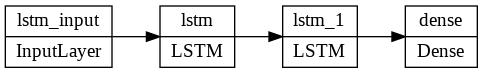

In [ ]:
tf.keras.utils.plot_model(
    model=model_lstm, to_file="lstm_model.png", show_shapes=False, rankdir="LR")

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss',
                                           patience=5, verbose=1, restore_best_weights=True),
             ModelCheckpoint(filepath='best_model.h5',
                                             monitor='val_loss',
                                             save_best_only=True, save_weights_only=False)]
#early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1, restore_best_weights=True)

history_lstm = model_lstm.fit(X_train_t, y_train, validation_split = 0.2, epochs=100,
          batch_size=32, verbose=1, callbacks=callbacks)

keras_model_best = load_model('best_model.h5')

Epoch 1/100
1545/1545 [==============================] - 18s 8ms/step - loss: 2.2795 - mean_squared_error: 2.2795 - val_loss: 2.2121 - val_mean_squared_error: 2.2121
Epoch 2/100
1545/1545 [==============================] - 11s 7ms/step - loss: 2.2006 - mean_squared_error: 2.2006 - val_loss: 2.0785 - val_mean_squared_error: 2.0785
Epoch 3/100
1545/1545 [==============================] - 15s 10ms/step - loss: 2.0468 - mean_squared_error: 2.0468 - val_loss: 1.9576 - val_mean_squared_error: 1.9576
Epoch 4/100
1545/1545 [==============================] - 11s 7ms/step - loss: 1.9580 - mean_squared_error: 1.9580 - val_loss: 1.9414 - val_mean_squared_error: 1.9414
Epoch 5/100
1545/1545 [==============================] - 11s 7ms/step - loss: 1.9169 - mean_squared_error: 1.9169 - val_loss: 1.9533 - val_mean_squared_error: 1.9533
Epoch 6/100
1545/1545 [==============================] - 11s 7ms/step - loss: 1.8736 - mean_squared_error: 1.8736 - val_loss: 1.8997 - val_mean_squared_error: 1.8997
Epo

In [ ]:
LSTM_pred = model_lstm.predict(X_test_t)
y_pred = pd.DataFrame(LSTM_pred[:,0])

In [ ]:
score = model_lstm.evaluate(X_test_t, y_test, batch_size=32)
print(score)

483/483 [==============================] - 2s 3ms/step - loss: 0.7690 - mean_squared_error: 0.7690
[0.7689802646636963, 0.7689802646636963]


In [ ]:
confirm_result(y_test,y_pred)

,Results
MAE,0.64756
RMSE,0.87691
R2,0.66420


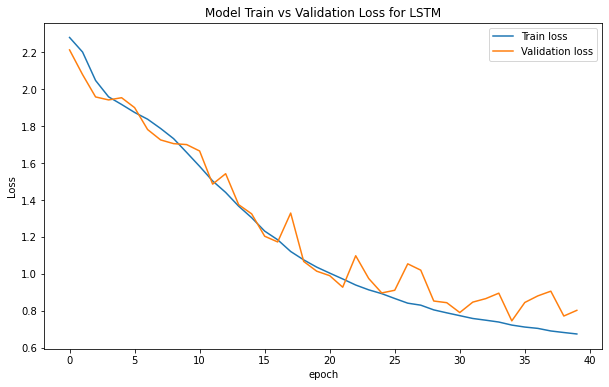

In [ ]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
 
plot_loss (history_lstm, 'LSTM')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


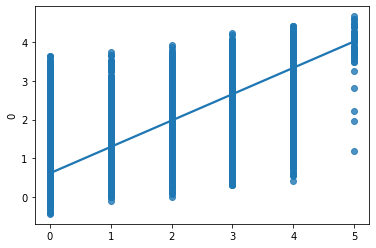

In [ ]:
import seaborn as sns

#create scatterplot with regression line and confidence interval lines
sns.regplot(y_test, y_pred)

###*LSTM1(512),Dense1,adam

In [ ]:
import tensorflow as tf
from keras.layers import LSTM 
from keras.models import Sequential, load_model 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

K.clear_session()
    
model_lstm = Sequential() # Sequeatial Model
model_lstm.add(LSTM(512, input_shape=(30, 1))) # (timestep, feature)
#model.add(Dense(10)) 
model_lstm.add(Dense(1)) # output = 1 
# model_lstm.compile(loss='mean_squared_error', optimizer='RMSprop') 
model_lstm.compile(loss='mean_squared_error', optimizer='adam', metrics='mean_squared_error') 
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               1052672   
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 1,053,185
Trainable params: 1,053,185
Non-trainable params: 0
_________________________________________________________________


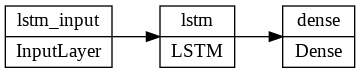

In [ ]:
tf.keras.utils.plot_model(
    model=model_lstm, to_file="lstm_model.png", show_shapes=False, rankdir="LR")

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss',
                                           patience=5, verbose=1, restore_best_weights=True),
             ModelCheckpoint(filepath='best_model.h5',
                                             monitor='val_loss',
                                             save_best_only=True, save_weights_only=False)]
#early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1, restore_best_weights=True)

history_lstm = model_lstm.fit(X_train_t, y_train, validation_split = 0.2, epochs=100,
          batch_size=32, verbose=1, callbacks=callbacks)

keras_model_best = load_model('best_model.h5')

Epoch 1/100
1545/1545 [==============================] - 14s 8ms/step - loss: 2.3327 - mean_squared_error: 2.3327 - val_loss: 2.2569 - val_mean_squared_error: 2.2569
Epoch 2/100
1545/1545 [==============================] - 12s 8ms/step - loss: 2.2336 - mean_squared_error: 2.2336 - val_loss: 2.2058 - val_mean_squared_error: 2.2058
Epoch 3/100
1545/1545 [==============================] - 12s 8ms/step - loss: 2.1158 - mean_squared_error: 2.1158 - val_loss: 2.0622 - val_mean_squared_error: 2.0622
Epoch 4/100
1545/1545 [==============================] - 12s 8ms/step - loss: 2.0301 - mean_squared_error: 2.0301 - val_loss: 2.0328 - val_mean_squared_error: 2.0328
Epoch 5/100
1545/1545 [==============================] - 13s 8ms/step - loss: 1.9767 - mean_squared_error: 1.9767 - val_loss: 1.9603 - val_mean_squared_error: 1.9603
Epoch 6/100
1545/1545 [==============================] - 12s 8ms/step - loss: 1.9459 - mean_squared_error: 1.9459 - val_loss: 1.9230 - val_mean_squared_error: 1.9230
Epoc

In [ ]:
LSTM_pred = model_lstm.predict(X_test_t)
y_pred = pd.DataFrame(LSTM_pred[:,0])

In [ ]:
score = model_lstm.evaluate(X_test_t, y_test, batch_size=32)
print(score)

483/483 [==============================] - 2s 3ms/step - loss: 0.6648 - mean_squared_error: 0.6648
[0.6647786498069763, 0.6647786498069763]


In [ ]:
confirm_result(y_test,y_pred)

,Results
MAE,0.56180
RMSE,0.81534
R2,0.70970


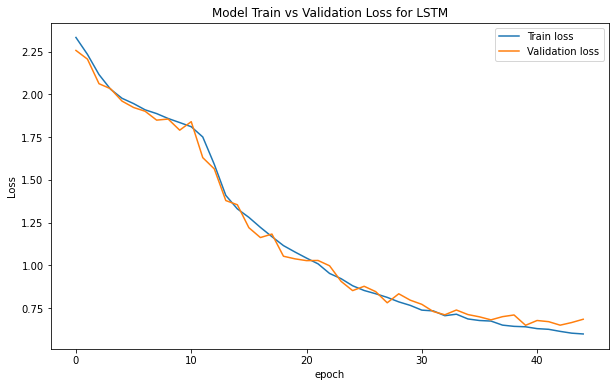

In [ ]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
 
plot_loss (history_lstm, 'LSTM')

###*LSTM1(512,128),Dense1,adam

In [ ]:
import tensorflow as tf
from keras.layers import LSTM 
from keras.models import Sequential, load_model 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

K.clear_session()
    
model_lstm = Sequential() # Sequeatial Model
model_lstm.add(LSTM(512, input_shape=(30, 1),return_sequences=True)) # (timestep, feature)
model_lstm.add(LSTM(units=128))
model_lstm.add(Dense(1)) # output = 1 
# model_lstm.compile(loss='mean_squared_error', optimizer='RMSprop') 
model_lstm.compile(loss='mean_squared_error', optimizer='adam', metrics='mean_squared_error') 
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 512)           1052672   
                                                                 
 lstm_1 (LSTM)               (None, 128)               328192    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,380,993
Trainable params: 1,380,993
Non-trainable params: 0
_________________________________________________________________


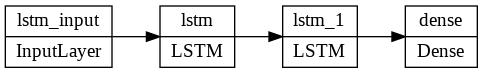

In [ ]:
tf.keras.utils.plot_model(
    model=model_lstm, to_file="lstm_model.png", show_shapes=False, rankdir="LR")

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss',
                                           patience=5, verbose=1, restore_best_weights=True),
             ModelCheckpoint(filepath='best_model.h5',
                                             monitor='val_loss',
                                             save_best_only=True, save_weights_only=False)]
#early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1, restore_best_weights=True)

history_lstm = model_lstm.fit(X_train_t, y_train, validation_split = 0.2, epochs=100,
          batch_size=32, verbose=1, callbacks=callbacks)

keras_model_best = load_model('best_model.h5')

Epoch 1/100
1545/1545 [==============================] - 19s 11ms/step - loss: 2.2666 - mean_squared_error: 2.2666 - val_loss: 2.1999 - val_mean_squared_error: 2.1999
Epoch 2/100
1545/1545 [==============================] - 16s 10ms/step - loss: 2.1000 - mean_squared_error: 2.1000 - val_loss: 2.1158 - val_mean_squared_error: 2.1158
Epoch 3/100
1545/1545 [==============================] - 16s 10ms/step - loss: 1.9920 - mean_squared_error: 1.9920 - val_loss: 1.9432 - val_mean_squared_error: 1.9432
Epoch 4/100
1545/1545 [==============================] - 16s 10ms/step - loss: 1.9303 - mean_squared_error: 1.9303 - val_loss: 1.8663 - val_mean_squared_error: 1.8663
Epoch 5/100
1545/1545 [==============================] - 17s 11ms/step - loss: 1.8850 - mean_squared_error: 1.8850 - val_loss: 1.8371 - val_mean_squared_error: 1.8371
Epoch 6/100
1545/1545 [==============================] - 16s 10ms/step - loss: 1.8537 - mean_squared_error: 1.8537 - val_loss: 1.7946 - val_mean_squared_error: 1.794

In [ ]:
LSTM_pred = model_lstm.predict(X_test_t)
y_pred = pd.DataFrame(LSTM_pred[:,0])

In [ ]:
score = model_lstm.evaluate(X_test_t, y_test, batch_size=32)
print(score)

483/483 [==============================] - 2s 4ms/step - loss: 0.6732 - mean_squared_error: 0.6732
[0.6732039451599121, 0.6732039451599121]


In [ ]:
confirm_result(y_test,y_pred)

,Results
MAE,0.57339
RMSE,0.82049
R2,0.70602


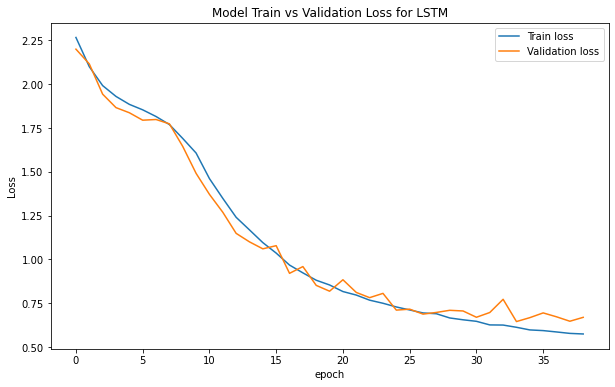

In [ ]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
 
plot_loss (history_lstm, 'LSTM')

##Result

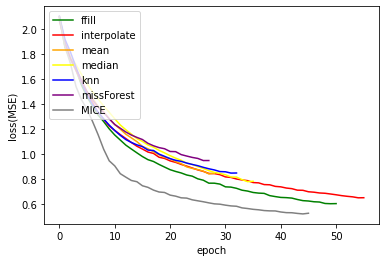

In [ ]:
figs, loss_ax = plt.subplots()
loss_ax.plot(hist_ffill.history['loss'],'y',label='ffill', color='green')
loss_ax.plot(hist_interpolate.history['loss'],'y',label='interpolate', color='red')
loss_ax.plot(hist_mean.history['loss'],'y',label='mean', color='orange')
loss_ax.plot(hist_median.history['loss'],'y',label='median', color='yellow')
loss_ax.plot(hist_knn.history['loss'],'y',label='knn', color='blue')
loss_ax.plot(hist_missForest.history['loss'],'y',label='missForest', color='purple')
loss_ax.plot(hist_mice.history['loss'],'y',label='MICE', color='gray')

loss_ax.legend(loc='upper left')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss(MSE)')


plt.show()

In [ ]:
!pip install shap

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
from keras import models
from keras.models import Sequential, load_model 


best_model = models.load_model("best_model.h5")

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
GRU_pred = best_model.predict(X_test_t)
y_pred = pd.DataFrame(GRU_pred[:,0])

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
df_y_test = pd.DataFrame(y_test)
df_y_test

,0
0,3.0
1,0.0
2,0.0
3,2.0
4,3.0
...,...
15440,2.0
15441,4.0
15442,2.0
15443,1.0


In [ ]:
df_error = df_y_test
df_error['err'] = df_y_test[0]-y_pred[0]
df_error

,0,err
0,3.0,0.668601
1,0.0,-0.945506
2,0.0,-1.160091
3,2.0,-1.298897
4,3.0,0.430136
...,...,...
15440,2.0,-0.968956
15441,4.0,-0.118439
15442,2.0,-0.723174
15443,1.0,-1.231082


Text(0, 0.5, 'error')

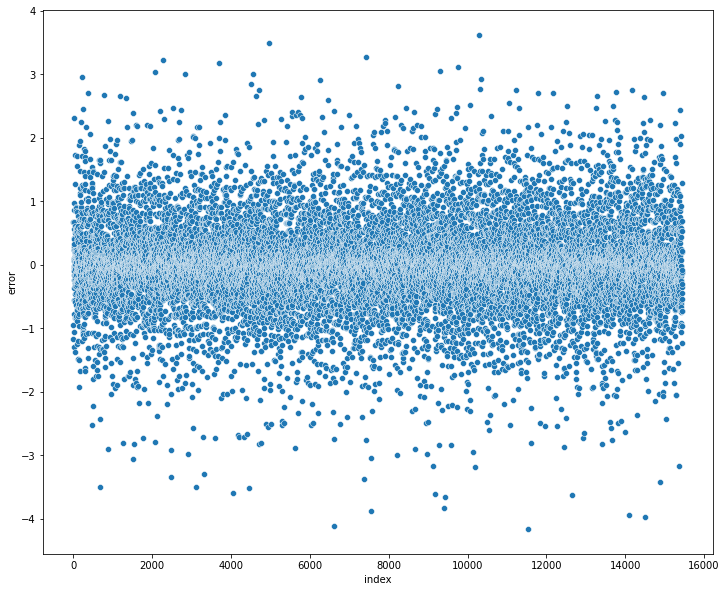

In [ ]:
import matplotlib.ticker as ticker
fig = plt.figure(figsize=[12,10])
#quarter count
ax1 = fig.add_subplot()
# ax1 = sns.barplot(x=df_y_test.index[7000:9000], y=df_y_test[0][7000:9000],color='black')
# ax1 = sns.barplot(x=y_pred.index[7000:9000], y=y_pred[0][7000:9000],color='blue')
ax1 = sns.scatterplot(x=df_error.index, y=df_error['err'])
#ax1 = sns.lineplot(x=y_filt_pred.index[7000:9000], y=y_filt_pred[0][7000:9000],color='blue')
ax1.set_xlabel("index")
ax1.set_ylabel("error(test-pred)")
#ax1.xaxis.set_major_locator(ticker.MultipleLocator(100))


In [ ]:
y_test

NameError: ignored

Text(0, 0.5, 'y_pred')

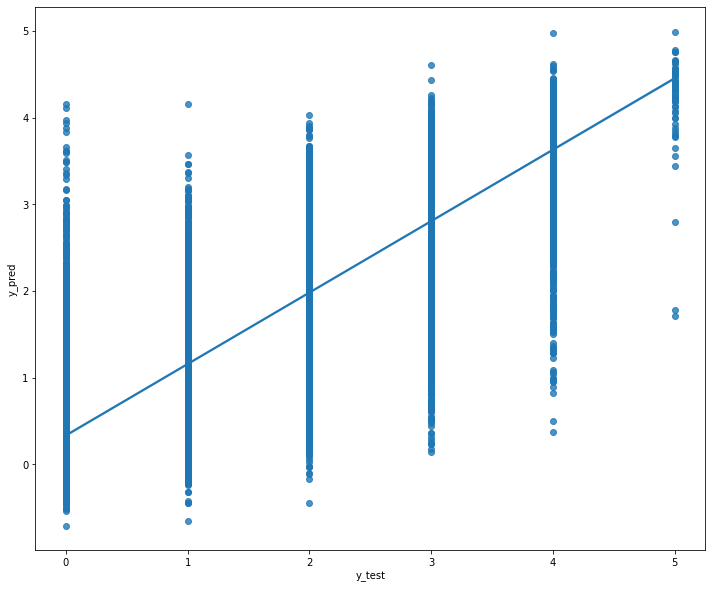

In [ ]:
import matplotlib.ticker as ticker
fig = plt.figure(figsize=[12,10])
#quarter count
ax1 = fig.add_subplot()
# ax1 = sns.barplot(x=df_y_test.index[7000:9000], y=df_y_test[0][7000:9000],color='black')
# ax1 = sns.barplot(x=y_pred.index[7000:9000], y=y_pred[0][7000:9000],color='blue')
ax1 = sns.regplot(x=df_y_test[0], y=y_pred[0])
#ax1 = sns.lineplot(x=y_filt_pred.index[7000:9000], y=y_filt_pred[0][7000:9000],color='blue')
ax1.set_xlabel("y_test")
ax1.set_ylabel("y_pred")
#ax1.xaxis.set_major_locator(ticker.MultipleLocator(100))


In [ ]:
from sklearn.metrics import confusion_matrix
#Get the confusion matrix
cf_matrix = confusion_matrix(df_y_test, y_pred)
print(cf_matrix)

ValueError: ignored

Text(0, 0.5, 'total_car_num')

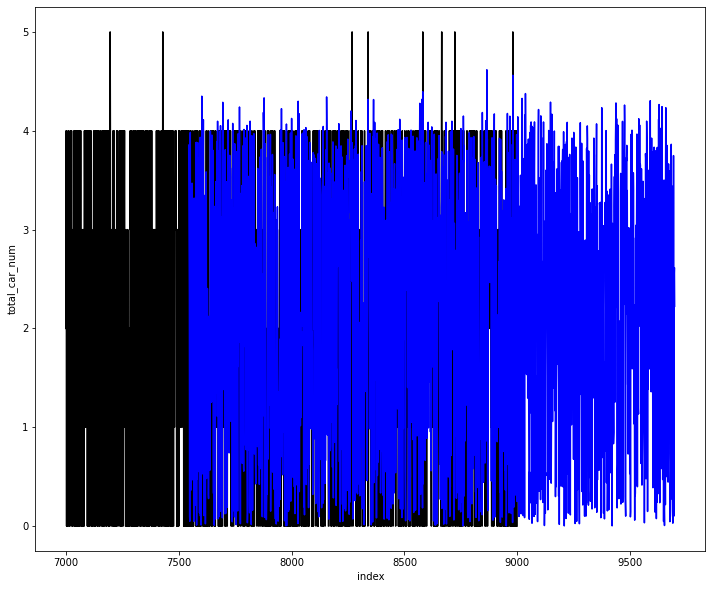

In [ ]:
import matplotlib.ticker as ticker
fig = plt.figure(figsize=[12,10])
# ax0 = fig.add_subplot(2,2,1)
# ax0 = sns.barplot(x=yearly_df.index, y=yearly_df['total_car_num'])
y_filt_test = df_y_test[df_y_test[0] >= 0]
y_filt_pred = y_pred[y_pred[0] >= 0]
#quarter count
ax1 = fig.add_subplot()
# ax1 = sns.barplot(x=df_y_test.index[7000:9000], y=df_y_test[0][7000:9000],color='black')
# ax1 = sns.barplot(x=y_pred.index[7000:9000], y=y_pred[0][7000:9000],color='blue')
ax1 = sns.lineplot(x=y_filt_test.index[7000:9000], y=y_filt_test[0][7000:9000],color='black')
ax1 = sns.lineplot(x=y_filt_pred.index[7000:9000], y=y_filt_pred[0][7000:9000],color='blue')
ax1.set_xlabel("index")
ax1.set_ylabel("total_car_num")
#ax1.xaxis.set_major_locator(ticker.MultipleLocator(100))


In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import shap
import time

# X,y = shap.datasets.diabetes()
# X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# rather than use the whole training set to estimate expected values, we summarize with
# a set of weighted kmeans, each weighted by the number of points they represent.
X_train_summary = shap.kmeans(X_train, 10)

def print_accuracy(f):
    print("Root mean squared test error = {0}".format(np.sqrt(np.mean((f(X_test) - y_test)**2))))
    time.sleep(0.5) # to let the print get out before any progress bars

shap.initjs()

In [ ]:
import shap
background = X_train_t[np.random.choice(X_train_t.shape[0],10000,replace=False)]

In [ ]:
explainer = shap.DeepExplainer(best_model, background)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


You have provided over 5k background samples! For better performance consider using smaller random sample.


In [ ]:
X_test_t.shape

(15445, 30, 1)

In [ ]:
# example image for each class for test set
x_test_dict = dict()
for i, l in enumerate(y_test):
  if len(x_test_dict)==10:
    break
  if l not in x_test_dict.keys():
    x_test_dict[l] = X_test_t[i]
# order by class
x_test_each_class = [x_test_dict[i] for i in sorted(x_test_dict)]
x_test_each_class = np.asarray(x_test_each_class)
# Compute predictions
predictions = best_model.predict(x_test_each_class)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


In [ ]:
import shap
background = X_train_t[np.random.choice(X_train_t.shape[0],500,replace=False)]
explainer = shap.DeepExplainer(best_model, background)
shap_values = explainer.shap_values(x_test_each_class)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [ ]:
# use Kernel SHAP to explain the network's predictions
explainer = shap.KernelExplainer(f, np.zeros((1,50)))
shap_values = explainer.shap_values(np.ones((1,50)), nsamples=1000)

In [ ]:
shap_values[0][0]

array([[-5.06310567e-04],
       [-1.00353970e-02],
       [ 7.86994817e-02],
       [-8.88219132e-02],
       [ 0.00000000e+00],
       [-1.35614176e-03],
       [-1.90764690e-01],
       [ 6.22088138e-02],
       [-2.17944205e-01],
       [ 1.10491348e-01],
       [ 9.79892500e-02],
       [ 1.94355955e-01],
       [-2.61776524e-04],
       [ 2.63329176e-02],
       [-2.01586818e-02],
       [-5.19479053e-02],
       [-3.76192004e-02],
       [ 1.81314850e-02],
       [ 1.82992406e-02],
       [-1.73458080e-02],
       [ 2.66442213e-03],
       [-9.11751971e-01],
       [ 2.57497597e-02],
       [-3.49657144e-01],
       [-4.26034417e-02],
       [ 0.00000000e+00],
       [ 6.85587099e-02],
       [ 2.16676028e-02],
       [ 1.37841262e-01],
       [ 1.40632007e-01]])

In [ ]:
e = explainer.expected_value
te = e.tolist()
te

[1.8826589584350586]

In [ ]:
df_mice = pd.DataFrame(imp_mice, columns=X.columns)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.0,0.0,0.103997,0.909091,0.0,0.040548,0.518519,0.5,0.636364,0.133333,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.103997,0.448617,0.0,0.040548,0.654321,0.5,0.181818,0.766667,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.103997,0.535573,0.0,0.040548,0.320988,0.5,0.181818,0.533333,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.173126,0.760213,0.0,0.050470,0.471747,0.5,0.909091,0.300000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.103997,0.932806,0.0,0.040548,0.432099,0.5,0.636364,0.100000,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15440,0.0,0.0,0.143806,0.651867,0.0,0.045266,0.404098,0.0,0.909091,0.733333,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
15441,1.0,0.0,0.103997,0.652174,0.0,0.040548,0.716049,0.0,0.818182,0.033333,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
15442,1.0,1.0,0.103997,0.721344,0.0,0.040548,0.530864,0.0,0.818182,0.066667,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
15443,0.0,1.0,0.103997,0.774704,0.0,0.040548,0.691358,0.5,0.818182,0.300000,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
shap.force_plot(float(explainer_logistic.expected_value), shap_values[0,:], X.iloc[0,:])

In [ ]:
df_test = pd.DataFrame(X_test)
df_test.columns=[['holiday','weekend','precipitation_type','temperature','station_name','precipitation','humid','year','month','day','hour','minute','second','fri','mon','sat','sun','thu','tue','wen','autumn','spring','summer','winter','afternoon','dawn','dinner','lunch','morning','night']]
df_test

,holiday,weekend,precipitation_type,temperature,station_name,precipitation,humid,year,month,day,...,autumn,spring,summer,winter,afternoon,dawn,dinner,lunch,morning,night
0,0.0,0.0,0.103997,0.909091,0.0,0.040548,0.518519,0.5,0.636364,0.133333,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.103997,0.448617,0.0,0.040548,0.654321,0.5,0.181818,0.766667,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.103997,0.535573,0.0,0.040548,0.320988,0.5,0.181818,0.533333,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.173126,0.760213,0.0,0.050470,0.471747,0.5,0.909091,0.300000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.103997,0.932806,0.0,0.040548,0.432099,0.5,0.636364,0.100000,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15440,0.0,0.0,0.143806,0.651867,0.0,0.045266,0.404098,0.0,0.909091,0.733333,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
15441,1.0,0.0,0.103997,0.652174,0.0,0.040548,0.716049,0.0,0.818182,0.033333,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
15442,1.0,1.0,0.103997,0.721344,0.0,0.040548,0.530864,0.0,0.818182,0.066667,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
15443,0.0,1.0,0.103997,0.774704,0.0,0.040548,0.691358,0.5,0.818182,0.300000,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
shap_values[0][1][:]

array([[-3.20456825e-03],
       [-5.86220555e-03],
       [ 1.14031164e-01],
       [-1.04427900e-01],
       [ 0.00000000e+00],
       [-1.60330732e-03],
       [ 2.27826996e-02],
       [ 2.65190133e-02],
       [-1.79643764e-01],
       [-4.19066510e-02],
       [-2.02544096e-02],
       [-3.25515622e-02],
       [-8.31067642e-05],
       [ 1.19392057e-02],
       [-2.62816034e-02],
       [-2.77348563e-02],
       [-2.97883060e-02],
       [ 3.12071840e-02],
       [-7.98177815e-02],
       [ 1.50519492e-02],
       [ 6.88530625e-02],
       [-4.60771841e-01],
       [-7.01279026e-02],
       [-1.92937981e-01],
       [-5.44616623e-02],
       [ 0.00000000e+00],
       [-1.18424282e-02],
       [ 2.02353214e-02],
       [-1.36591667e-01],
       [-2.41019298e-03]])

In [ ]:
df_test[:50]

,holiday,weekend,precipitation_type,temperature,station_name,precipitation,humid,year,month,day,...,autumn,spring,summer,winter,afternoon,dawn,dinner,lunch,morning,night
0,0.0,0.0,0.103997,0.909091,0.0,0.040548,0.518519,0.5,0.636364,0.133333,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.103997,0.448617,0.0,0.040548,0.654321,0.5,0.181818,0.766667,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.103997,0.535573,0.0,0.040548,0.320988,0.5,0.181818,0.533333,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.173126,0.760213,0.0,0.050470,0.471747,0.5,0.909091,0.300000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.103997,0.932806,0.0,0.040548,0.432099,0.5,0.636364,0.100000,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.0,1.000000,0.519763,0.0,0.222066,0.925926,0.5,0.181818,0.866667,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,0.0,0.0,0.103997,0.581028,0.0,0.040548,0.962963,0.5,0.363636,0.566667,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,0.0,1.0,0.239713,0.353950,0.0,0.066019,0.657740,0.0,1.000000,0.366667,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
8,0.0,0.0,0.053084,0.196855,0.0,0.013183,0.356559,0.5,0.090909,0.533333,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.103997,0.800395,0.0,0.040548,0.851852,0.5,0.636364,0.066667,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# shap.force_plot(explainer.expected_value[], shap_values[0][0], df_x_test)
shap.initjs()
shap.force_plot(float(explainer.expected_value), shap_values[0][1], X_test)

#POC1.5 - DL MODEL : VIF(다중공선성, VIF>10)

##VIF 처리

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

dfX = pd.DataFrame(df_new.iloc[:, 1:])
dfY = pd.DataFrame(df_new.iloc[:, :1])

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(dfX.values, i) for i in range(dfX.shape[1])]
vif["features"] = dfX.columns
vif = vif.sort_values("VIF Factor").reset_index(drop=True)
vif

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,1.15118,day
1,1.18864,holiday
2,1.33318,second
3,1.46044,minute
4,1.60021,precipitation
5,1.76886,precipitation_type
6,2.55950,humid
7,12.62887,hour
8,15.75096,temperature
9,281.31976,h2car_regis_num


###p-value>0.05제거

In [ ]:
import statsmodels.api as sm
#Train the MLR / 회귀모델적합
fullModel = sm.OLS(dfY,dfX)
fittedFullModel = fullModel.fit()
 
#R-Squre 가 높고 , 대부분의 변수들이 유의함.
print(fittedFullModel.summary())

                            OLS Regression Results                            
Dep. Variable:          total_car_num   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     52.83
Date:                Wed, 22 Jun 2022   Prob (F-statistic):          1.73e-254
Time:                        11:25:59   Log-Likelihood:                -9942.3
No. Observations:                6305   AIC:                         1.994e+04
Df Residuals:                    6277   BIC:                         2.013e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
holiday               -0.1688      0

### 변수선택법

In [ ]:
#변수선택법 적용 hour, day, wen, summer, dawn
dfX_vif=dfX.drop(['holiday', 'month', 'year', 'hour', 'second'], axis=1) 
dfX_vif

,weekend,precipitation_type,temperature,station_name,precipitation,humid,day,minute,fri,mon,...,summer,winter,afternoon,dawn,dinner,lunch,morning,night,date,h2car_regis_num
0,0.00000,0.09940,0.73299,0.00000,0.03982,0.40741,0.53333,0.49153,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000
1,0.00000,0.09940,0.77987,0.00000,0.03982,0.23457,0.56667,0.84746,1.00000,0.00000,...,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,0.00000,0.09940,0.77987,0.00000,0.03982,0.23457,0.56667,0.46610,1.00000,0.00000,...,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,0.00000,0.09940,0.77783,0.00000,0.03982,0.29630,0.56667,0.46610,1.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,0.00000,0.09940,0.77783,0.00000,0.03982,0.29630,0.56667,0.46610,1.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6300,0.00000,0.08949,0.21380,0.00000,0.01070,0.57954,0.16667,0.46610,0.00000,0.00000,...,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000
6301,0.00000,0.08740,0.21912,0.00000,0.01078,0.56604,0.16667,0.46610,0.00000,0.00000,...,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000
6302,0.00000,0.08588,0.22409,0.00000,0.01087,0.55321,0.16667,0.46610,0.00000,0.00000,...,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000
6303,0.00000,0.08957,0.22583,0.00000,0.01114,0.54636,0.16667,0.46610,0.00000,0.00000,...,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000


###학습데이터셋 생성

In [ ]:
X, y = dfX_vif.values, dfY.values
y = y. flatten()
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 0,
                                                  )
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 0,
                                                  )

print('X_train :', X_train)
print('X_valid :', X_valid)
print('X_test :', X_test)
print('y_train :', y_train)
print('y_valid :', y_valid)
print('y_test :', y_test)

X_train : [[0.         0.1227509  0.19041761 ... 1.         0.484375   0.2038739 ]
 [1.         0.09939985 0.48840028 ... 0.         0.5        0.49787528]
 [1.         0.09939985 0.53324169 ... 1.         0.00520833 0.05405672]
 ...
 [0.         0.26654304 0.44674471 ... 1.         0.015625   0.13953948]
 [0.         0.09939985 0.48228554 ... 1.         0.48958333 0.29103666]
 [0.         0.09939985 0.49247677 ... 1.         0.48958333 0.29103666]]
X_valid : [[0.         0.1406452  0.64626814 ... 0.         0.01041667 0.09714399]
 [0.         0.09939985 0.46597957 ... 1.         0.01041667 0.09714399]
 [0.         0.09939985 0.50878274 ... 0.         0.49479167 0.41041605]
 ...
 [1.         0.09939985 0.45782659 ... 0.         0.01041667 0.09714399]
 [0.         0.07721763 0.17166528 ... 1.         0.47916667 0.15337484]
 [0.         0.09939985 0.52305046 ... 0.         0.5        0.49787528]]
X_test : [[0.         0.1406452  0.64626814 ... 0.         0.01041667 0.09714399]
 [0.      

In [ ]:
X_train_t = X_train.reshape(X_train.shape[0], 27, 1)
X_valid_t = X_valid.reshape(X_valid.shape[0], 27, 1)
X_test_t = X_test.reshape(X_test.shape[0], 27, 1)

print("최종 DATA")
print(X_train_t.shape)

최종 DATA
(5044, 27, 1)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def confirm_result(y_test,y_pred):
  MAE=mean_absolute_error(y_test,y_pred)
  RMSE=np.sqrt(mean_squared_error(y_test,y_pred))
  #MSLE = mean_squared_log_error(y_test,y_pred)
  R2 = r2_score(y_test,y_pred)
  pd.options.display.float_format='{:.5f}'.format
  
  Result = pd.DataFrame(data=[MAE,RMSE,R2],index=['MAE','RMSE','R2'],columns=['Results'])
  return Result

##MODEL 적용

### VIF-GRU1(512),Dense1,adam

In [ ]:
import tensorflow as tf
from keras.models import Sequential, load_model 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.recurrent_v2 import GRU

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

K.clear_session()
    
model_gru = Sequential() # Sequeatial Model 
model_gru.add(GRU(units=512,input_shape=(27, 1)))
model_gru.add(Dense(1)) # output = 1 
#model_gru.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error', 'r2_score'])
model_gru.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error']) 
model_gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 512)               791040    
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 791,553
Trainable params: 791,553
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks = [EarlyStopping(monitor='val_loss',
                                           patience=5, verbose=1, restore_best_weights=True),
             ModelCheckpoint(filepath='best_model.h5',
                                             monitor='val_loss',
                                             save_best_only=True, save_weights_only=False)]
#early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1, restore_best_weights=True)

history_gru = model_gru.fit(X_train_t, y_train, validation_split = 0.2, epochs=100,
          batch_size=32, verbose=1, callbacks=callbacks)

keras_model_best = load_model('best_model.h5')

Epoch 1/100
127/127 [==============================] - 6s 18ms/step - loss: 2.0599 - mean_squared_error: 2.0599 - val_loss: 1.7985 - val_mean_squared_error: 1.7985
Epoch 2/100
127/127 [==============================] - 1s 10ms/step - loss: 1.7260 - mean_squared_error: 1.7260 - val_loss: 1.7332 - val_mean_squared_error: 1.7332
Epoch 3/100
127/127 [==============================] - 1s 10ms/step - loss: 1.6575 - mean_squared_error: 1.6575 - val_loss: 1.7010 - val_mean_squared_error: 1.7010
Epoch 4/100
127/127 [==============================] - 1s 10ms/step - loss: 1.6315 - mean_squared_error: 1.6315 - val_loss: 1.7004 - val_mean_squared_error: 1.7004
Epoch 5/100
127/127 [==============================] - 1s 10ms/step - loss: 1.6033 - mean_squared_error: 1.6033 - val_loss: 1.6508 - val_mean_squared_error: 1.6508
Epoch 6/100
127/127 [==============================] - 1s 10ms/step - loss: 1.5744 - mean_squared_error: 1.5744 - val_loss: 1.6491 - val_mean_squared_error: 1.6491
Epoch 7/100
127/

In [ ]:
GRU_pred = model_gru.predict(X_test_t)
y_pred = pd.DataFrame(GRU_pred[:,0])

In [ ]:
# evaluate : accuracy와 loss 알 수 있음
score = model_gru.evaluate(X_test_t, y_test, batch_size=32)
print('MSE = ', score)

40/40 [==============================] - 0s 4ms/step - loss: 1.3039 - mean_squared_error: 1.3039
MSE =  [1.3039110898971558, 1.3039110898971558]


In [ ]:
confirm_result(y_test,y_pred)

,Results
MAE,0.97899
RMSE,1.14189
R2,0.21165


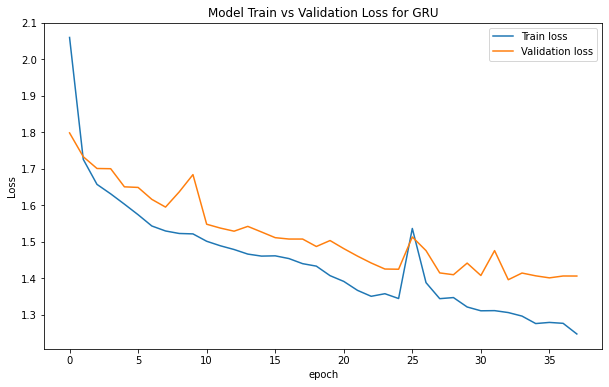

In [ ]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
 
plot_loss (history_gru, 'GRU')

###VIF-LSTM1(512,256),Dense1,adam

In [ ]:
import tensorflow as tf
from keras.layers import LSTM 
from keras.models import Sequential, load_model 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

K.clear_session()
    
model_lstm = Sequential() # Sequeatial Model
model_lstm.add(LSTM(512, input_shape=(28, 1),return_sequences=True)) # (timestep, feature)
model_lstm.add(LSTM(units=256))
model_lstm.add(Dense(1)) # output = 1 
# model_lstm.compile(loss='mean_squared_error', optimizer='RMSprop') 
model_lstm.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error']) 
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 28, 512)           1052672   
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 1,840,385
Trainable params: 1,840,385
Non-trainable params: 0
_________________________________________________________________


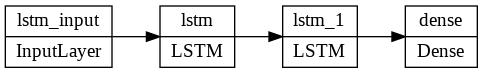

In [ ]:
tf.keras.utils.plot_model(
    model=model_lstm, to_file="lstm_model.png", show_shapes=False, rankdir="LR")

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss',
                                           patience=5, verbose=1, restore_best_weights=True),
             ModelCheckpoint(filepath='best_model.h5',
                                             monitor='val_loss',
                                             save_best_only=True, save_weights_only=False)]
#early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1, restore_best_weights=True)

history_lstm = model_lstm.fit(X_train_t, y_train, validation_split = 0.2, epochs=100,
          batch_size=32, verbose=1, callbacks=callbacks)

keras_model_best = load_model('best_model.h5')

Epoch 1/100
127/127 [==============================] - 7s 21ms/step - loss: 1.8811 - mean_squared_error: 1.8811 - val_loss: 1.7851 - val_mean_squared_error: 1.7851
Epoch 2/100
127/127 [==============================] - 2s 13ms/step - loss: 1.6870 - mean_squared_error: 1.6870 - val_loss: 1.7397 - val_mean_squared_error: 1.7397
Epoch 3/100
127/127 [==============================] - 2s 13ms/step - loss: 1.6854 - mean_squared_error: 1.6854 - val_loss: 1.7279 - val_mean_squared_error: 1.7279
Epoch 4/100
127/127 [==============================] - 2s 13ms/step - loss: 1.6600 - mean_squared_error: 1.6600 - val_loss: 1.7275 - val_mean_squared_error: 1.7275
Epoch 5/100
127/127 [==============================] - 2s 17ms/step - loss: 1.6474 - mean_squared_error: 1.6474 - val_loss: 1.7135 - val_mean_squared_error: 1.7135
Epoch 6/100
127/127 [==============================] - 2s 13ms/step - loss: 1.6553 - mean_squared_error: 1.6553 - val_loss: 1.7077 - val_mean_squared_error: 1.7077
Epoch 7/100
127/

In [ ]:
LSTM_pred = model_lstm.predict(X_test_t)
y_pred = pd.DataFrame(LSTM_pred[:,0])

In [ ]:
score = model_lstm.evaluate(X_test_t, y_test, batch_size=32)
print(score)

40/40 [==============================] - 0s 5ms/step - loss: 1.3390 - mean_squared_error: 1.3390
[1.3390259742736816, 1.3390259742736816]


In [ ]:
confirm_result(y_test,y_pred)

,Results
MAE,0.97629
RMSE,1.15716
R2,0.19042


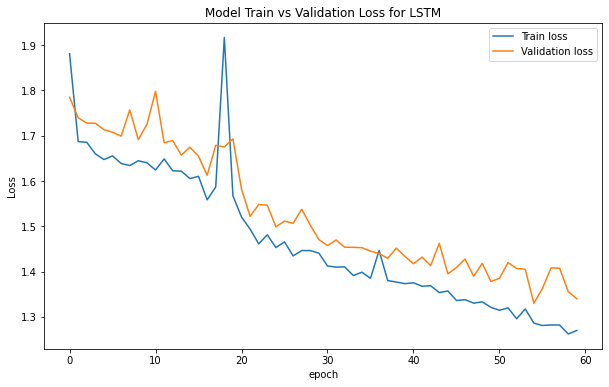

In [ ]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
 
plot_loss (history_lstm, 'LSTM')

###VIF 재확인

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_done = pd.DataFrame()
vif_done["VIF Factor"] = [variance_inflation_factor(dfX_vif.values, i) for i in range(dfX_vif.shape[1])]
vif_done["features"] = dfX_vif.columns
vif_done = vif_done.sort_values("VIF Factor").reset_index(drop=True)
vif_done

,VIF Factor,features
0,1.00023,dawn
1,1.00223,second
2,1.10609,holiday
3,1.29859,sun
4,1.33759,thu
5,1.34817,wen
6,1.35199,dinner
7,1.36405,tue
8,1.70027,summer
9,1.87214,spring


#POC2 - DL MODEL : 피쳐추가

#1시간 간격 groupby mean

In [ ]:
merge_df

,total_car_num,holiday,weekend,precipitation_type,temperature,station_name,precipitation,humid,year,month,...,winter,afternoon,dawn,dinner,lunch,morning,night,time,date,h2car_regis_num
0,2.0,0.0,0.0,0.000000,23.000000,26.0,0.000000,52.000000,20.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020-09-17 21:20:28,2020.09,9494
1,3.0,0.0,0.0,0.000000,23.000000,26.0,0.000000,52.000000,20.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020-09-17 21:38:08,2020.09,9494
2,4.0,0.0,0.0,0.000000,25.300000,26.0,0.000000,38.000000,20.0,9.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-09-18 16:45:41,2020.09,9494
3,4.0,0.0,0.0,0.000000,25.300000,26.0,0.000000,38.000000,20.0,9.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-09-18 16:50:00,2020.09,9494
4,4.0,0.0,0.0,0.000000,25.300000,26.0,0.000000,38.000000,20.0,9.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-09-18 16:55:00,2020.09,9494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77217,3.0,0.0,0.0,-0.007601,-2.072026,26.0,-0.552183,63.496539,22.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2022-01-06 16:40:00,2022.01,19613
77218,3.0,0.0,0.0,-0.007816,-2.105922,26.0,-0.552909,63.463687,22.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2022-01-06 16:45:00,2022.01,19613
77219,4.0,0.0,0.0,-0.015731,-1.929274,26.0,-0.558184,62.784255,22.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2022-01-06 16:50:00,2022.01,19613
77220,2.0,0.0,0.0,-0.000545,-2.384258,26.0,-0.549811,64.044561,22.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2022-01-06 16:55:00,2022.01,19613


In [ ]:
#merge_df['time'] = pd.to_datetime(merge_df['time'], format='%Y-%m-%d %Hh:%Mm:%Ss', errors='raise')
merge_df['time'] = pd.to_datetime(merge_df['time'], errors='raise')
df_groupby_hr = merge_df.groupby(merge_df['time'].dt.strftime('%Y-%m-%d-%Hh')).mean()
df_groupby_hr

,total_car_num,holiday,weekend,precipitation_type,temperature,station_name,precipitation,humid,year,month,...,summer,winter,afternoon,dawn,dinner,lunch,morning,night,date,h2car_regis_num
time,,,,,,,,,,,,,,,,,,,,,
2020-09-17-21h,2.500000,0.0,0.0,0.000000,23.000000,26.0,0.000000,52.000000,20.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020.09,9494.0
2020-09-18-16h,4.000000,0.0,0.0,0.000000,25.300000,26.0,0.000000,38.000000,20.0,9.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020.09,9494.0
2020-09-18-17h,4.000000,0.0,0.0,0.000000,25.300000,26.0,0.000000,38.000000,20.0,9.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020.09,9494.0
2020-09-18-18h,3.916667,0.0,0.0,0.000000,25.200000,26.0,0.000000,43.000000,20.0,9.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2020.09,9494.0
2020-09-18-19h,3.500000,0.0,0.0,0.000000,25.200000,26.0,0.000000,43.000000,20.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020.09,9494.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-06-13h,2.916667,0.0,0.0,-0.011006,-2.472380,26.0,-0.561063,65.942785,22.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2022.01,19613.0
2022-01-06-14h,3.416667,0.0,0.0,-0.013328,-2.211258,26.0,-0.559647,64.849417,22.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2022.01,19613.0
2022-01-06-15h,3.833333,0.0,0.0,-0.015008,-1.967682,26.0,-0.557851,63.809931,22.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2022.01,19613.0


In [ ]:
df_groupby_hr.reset_index(inplace=True)

In [ ]:
df_new2=df_groupby_hr.drop(['total_car_num'], axis=1)
df_new2

,time,holiday,weekend,precipitation_type,temperature,station_name,precipitation,humid,year,month,...,summer,winter,afternoon,dawn,dinner,lunch,morning,night,date,h2car_regis_num
0,2020-09-17-21h,0.0,0.0,0.000000,23.000000,26.0,0.000000,52.000000,20.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020.09,9494.0
1,2020-09-18-16h,0.0,0.0,0.000000,25.300000,26.0,0.000000,38.000000,20.0,9.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020.09,9494.0
2,2020-09-18-17h,0.0,0.0,0.000000,25.300000,26.0,0.000000,38.000000,20.0,9.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020.09,9494.0
3,2020-09-18-18h,0.0,0.0,0.000000,25.200000,26.0,0.000000,43.000000,20.0,9.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2020.09,9494.0
4,2020-09-18-19h,0.0,0.0,0.000000,25.200000,26.0,0.000000,43.000000,20.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020.09,9494.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6300,2022-01-06-13h,0.0,0.0,-0.011006,-2.472380,26.0,-0.561063,65.942785,22.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2022.01,19613.0
6301,2022-01-06-14h,0.0,0.0,-0.013328,-2.211258,26.0,-0.559647,64.849417,22.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2022.01,19613.0
6302,2022-01-06-15h,0.0,0.0,-0.015008,-1.967682,26.0,-0.557851,63.809931,22.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2022.01,19613.0
6303,2022-01-06-16h,0.0,0.0,-0.010913,-1.882013,26.0,-0.552644,63.255379,22.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2022.01,19613.0
